In [338]:
import numpy as np_force
import scipy as sc_force
import autograd.numpy as np
import autograd.scipy as sc
from autograd import grad, elementwise_grad, value_and_grad
from matplotlib import pyplot as plt
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.misc as misc
from scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
import copy

In [141]:
# from autograd import grad_and_aux
# grad_and_aux?
# def test_func(x):
#     out_aux1 = np.linspace(1,x,100)**2
#     out_aux2 = np.exp(1j*out_aux1)
#     out_val = np.sum(out_aux1)
#     out_dict = {
#         'x' : out_aux1,
#         'y' : out_aux2
#     }
#     return out_val, out_dict

# test_aux = grad_and_aux(test_func)
# tg, tx = test_aux(5.)

# plt.figure()
# plt.plot(tx['x']._value)
# plt.plot(np.real(tx['y']._value))
# plt.plot(np.imag(tx['y']._value))
# print(tg)

training list shape:
(10, 3, 512, 512)
897515.7365187192
897515.7365187192
1795026.5
(10, 3, 512, 512)


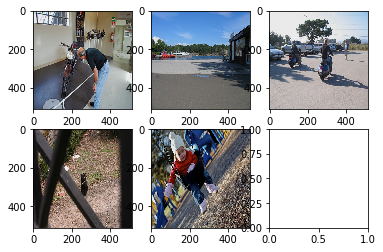

In [794]:
# Setup training data
from os import listdir
from os.path import isfile, join

dataset_dir = '/Users/nick.antipa/Documents/TrainingData/NaturalImages512/'
imfiles = [f for f in listdir(dataset_dir) if isfile(join(dataset_dir, f))]

Nfiles = len(imfiles)
Ntrain = 10
Nbatch = 6
Nval = 5
train_inds = np.random.choice(Nfiles, Ntrain, replace=False)


train_files = [imfiles[n] for n in train_inds]

[imfiles.pop(n) for n in sorted(train_inds, reverse=True)]


val_inds = np.random.choice(Nfiles-Ntrain, Nval, replace=False)

val_files = [imfiles[n] for n in val_inds]

# Load training list
imnormalize = lambda x:x/np.max(x)

def read_im_list_rgb(folder, files):
    return_list = []
    [return_list.append(np.moveaxis(imnormalize(misc.imread(folder+files[n]).astype('float32')), -1, 0))  for n in range(len(files))]
    return return_list

train_list = read_im_list_rgb(dataset_dir, train_files)
print('training list shape:')
print(np.shape(train_list))


#[val_list.append(imnormalize(misc.imread(dataset_dir+val_files[n]).astype('float32'))) for n in range(Nval)]
val_list = read_im_list_rgb(dataset_dir, val_files)

subrows = int(np.floor(np.sqrt(Nval)))
subcols = int(np.ceil(np.sqrt(Nval)))
fig, ax = plt.subplots(subrows, subcols)#, figsize=(20,20))
c = -1
for n in range(subrows):
    for m in range(subcols):
        c += 1
        if c < Nval:
            ax[n,m].imshow(np.moveaxis(val_list[c], 0, -1))
            

        
losstest, outtest = sgdtest(1., 1, 1, 10, train_list, Ntrain)
print(outtest['loss'])

lossgradtest = grad_and_aux(sgdtest)

g, gtest = lossgradtest(1., 1, 1, 10, train_list, Ntrain)
print(gtest['loss']._value)
print(g)
print(np.shape(outtest['resid_ims']))



In [694]:
# Operate on last 2 dims to match np.fft convention
def pad_func(x, padfrac):
    if np.shape(padfrac) == ():
        if x.ndim is 2:
            padfrac = ((padfrac, padfrac), (padfrac, padfrac))
        elif x.ndim is 3:
            #If x is 3D and pad a single pad value was passed in, assume padding on last 2 dims only
            padfrac = ((0,0), (padfrac, padfrac), (padfrac, padfrac))
    #print(padfrac)
        
        
    padr = [];#np.zeros(x.ndim).astype('int')
    for n in range(x.ndim):
        pwpre = np.ceil(padfrac[n-2][0]*x.shape[n-2]).astype('int')
        pwpost = np.ceil(padfrac[n-2][1]*x.shape[n-2]).astype('int')
        padr.append((pwpre,pwpost))
        #print(padr)
        x = zero_pad_ag(x, padr[n], n-2)
        
    
    
    
    return x

def crop_func(x,crop_size):
    # Crops the center matching the size in the tuple crop_size. Implicitly deals with higher dimensions?
    cstart = []
    cent = []
    for n in range(x.ndim):
        cstart.append((x.shape[n]-crop_size[n])//2)
    slicer = tuple(slice(cstart[n],cstart[n]+crop_size[n],1) for n in range(len(crop_size)))
    return(x[slicer])


def zero_pad_ag(x, pad_tuple, pad_dim):
    zarg_pre = tuple(pad_tuple[0] if z == pad_dim % x.ndim else x.shape[z] for z in range(x.ndim))
    zpre = np.zeros(zarg_pre)
    zarg_post = tuple(pad_tuple[1] if z == pad_dim % x.ndim else x.shape[z] for z in range(x.ndim))
    zpost = np.zeros(zarg_post)
    out = np.concatenate((zpre, x, zpost), axis=pad_dim)
    
    return out

In [695]:
x = test
t = np.arange(test.ndim)
pad_tuple = (2,4)
pad_dim = -1
#print(tuple(pad_tuple[0] if z == np.arange(x.ndim)[pad_dim] else x.shape[z] for z in range(x.ndim)))
print(tuple(pad_tuple[0] if z == pad_dim % x.ndim else x.shape[z] for z in range(x.ndim)))
print(pad_dim % test.ndim)

(10, 2)
1


(3, 6, 60)
(3, 2, 28)


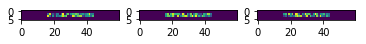

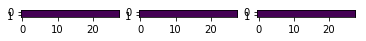

In [696]:
test = np.random.rand(3,2,28)


#ax[0].imshow(np.squeeze(test))
#ax[1].imshow(np.squeeze(out_test))
padtest = pad_func(test,.55)
fig, ax = plt.subplots(1,padtest.shape[0])
print(np.shape(padtest))
plt.figure()
[ax[n].imshow(np.squeeze(padtest[n,:,:,])) for n in range(len(ax))]

croptest = crop_func(padtest, np.shape(test))
fig, ax = plt.subplots(1,croptest.shape[0])
print(np.shape(croptest))
plt.figure()
[ax[n].imshow(np.squeeze(croptest[n,:,:,] - test[n,:,:])) for n in range(len(ax))]



In [697]:
pad_dim = 2
active_dims = [y for y in range(test.ndim) if y != pad_dim]
pad_tup = (7,4)
print(active_dims)
# for n in active_dims:
#     print(n)
zarg_pre = tuple(pad_tup[0] if z == pad_dim else test.shape[z] for z in range(test.ndim))
print(zarg_pre)
    

[0, 1]
(3, 2, 7)


In [698]:
def propagate_field_freq(lam, z, U, Fx, Fy, padfrac=0):
    k = 2*np.pi/lam

    #siz = np.shape(U)
    #fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
    #fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
    #x = np.linspace(-siz[1]/2*ps,siz[1]/2*ps,siz[1])
    #y = np.linspace(-siz[0]/2*ps,siz[0]/2*ps,siz[0])
    #X,Y = np.meshgrid(x,y)
    #Fx,Fy = np.meshgrid(fx,fy)
    if padfrac != 0:
        shape_orig = np.shape(U)
        U = pad_func(U, padfrac, 'edge')

        Fx, Fy = np.meshgrid(np.linspace(np.min(Fx), np.max(Fx), U.shape[0]), np.linspace(np.min(Fy), np.max(Fy), U.shape[1]))
        
    Uf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(U)))
    Hf = np.exp(1j*2*np.pi*z/lam * np.sqrt(1-(lam*Fx)**2 - (lam*Fy)**2))
    Up = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Uf*Hf)))
    if padfrac != 0:
        Up = crop_func(Up, shape_orig)
    return Up

In [699]:
# Grad examples:
# y = f(X,Z)
# plt.figure()
# plt.imshow(y)
# gradf = elementwise_grad(f)
# plt.figure()
# plt.imshow(gradf(X,Z))
# plt.figure()
# gradf2 = elementwise_grad(f,argnum=(0,1))
# gradout = gradf2(X,Z)
# plt.imshow(gradout[1])

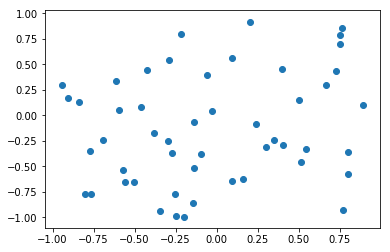

In [700]:
Nlenslets = 50
samples = (256,256)
xrng = (-1,1)
yrng = (-1,1)
x1 = np.random.rand(Nlenslets)*2-1

y1 = np.random.rand(Nlenslets)*2-1
R = np.random.rand(Nlenslets)*5+16

xg = np.linspace(xrng[0], xrng[1], samples[0])
yg = np.linspace(yrng[0], yrng[1], samples[1])
xg, yg = np_force.meshgrid(xg,yg)
ca = .9
aperR = np.sqrt(xg**2 + yg**2)<ca
plt.figure()
plt.scatter(x1,y1)

In [701]:
a = 1
print(np.shape(a))

()


In [702]:
def make_lenslet_surface_ag(Xlist, Ylist, Rlist, xg, yg, offset):
    # Takes in Xlist, Ylist and Rlist: floating point center and radius values for each lenslet
    # xrng and yrng: x and y range (tuple) over which to define grid
    # samples: tuple of number of samplex in x and y, respectively
    #
    # Outputs: T, the aperture thickness function. 
    
    # If only one radius provided, use same radius for everything
    if np.shape(Rlist) == ():
        Rlist = np.ones_like(Xlist)*Rlist
        
    Nlenslets = Xlist.shape[0]
    T = np.zeros_like(xg)
    for n in range(Nlenslets):
        sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2))-Rlist[n]+offset
        T = np.maximum(T,sph)
    
    return T-offset

In [703]:
def make_lens_surface_ag(R, xg, yg):
    return(np.real(np.sqrt(0j+R**2 - xg**2 - yg**2)))

In [704]:
def gen_psf_ag(surface, ior, t, z_obj, obj_def, field, CA, lmbda, xg, yg, Fx, Fy,pupil_phase=0, prop_pad = 0):
    # Inputs:
    # surface: single surface thickness function, units: mm
    # ior : index of refraction of bulk material
    # t : thickness of surface (i.e. distance to output plane)
    # z_obj : distance from object plane. +Inf means object at infinity
    # object_def : 'angle' for angular field definition, 'obj_height' for finite
    # field : tuple (x,y) wavefront field definition. (0,0) is on-axis. Interpreted in context of object_def
    # CA: radius of clear aperture in mm
    # pupil_aberration: additional pupil phase, in radians!
    # lmbda: wavelength in mm
    # xg and yg are the spatial grid (pixel spacing in mm)
    # Fx : frequency grid in 1/mm
    # Fy : same as Fx
    k = np.pi*2/lmbda
    
    if obj_def is 'angle':
        ramp_coeff_x = -np.tan(field[0]*np.pi/180)
        ramp_coeff_y = -np.tan(field[1]*np.pi/180)
        ramp = xg*ramp_coeff_x + yg*ramp_coeff_y
        if z_obj is 'inf':
            U_in = np.exp(1j*k*(ramp))
        else:
            U_in = np.exp(1j*k*(-z_obj*np.sqrt(1-(xg/z_obj)**2 - (yg/z_obj)**2) + ramp))
    elif obj_def is 'obj_height':
        if z_obj is 'inf':
            raise Exception('cannot use obj_height and object at infinity')
        else:
            U_in = np.exp(1j*-z_obj*k*np.sqrt(1-((xg-field[0])/z_obj)**2 - ((yg-field[1])/z_obj)**2))
    
    U_out = U_in * np.exp(1j*(k*(ior-1)*surface + pupil_phase))
    amp = np.sqrt(xg**2 + yg**2) <= CA
    U_prop = propagate_field_freq(lmbda, t, amp*U_out, Fx, Fy)
    
    psf = np.abs(U_prop)**2
    return(psf/np.sum(psf))
    

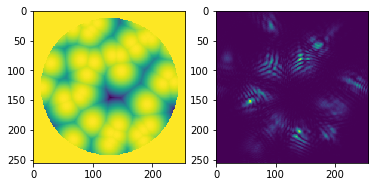

In [705]:
ps = (xrng[1] - xrng[0])/samples[0]
lens_rad = 12.0
lens_f = 1/(.51/lens_rad)
x_list = np.random.rand(50)*1.8 - .9
y_list = np.random.rand(50)*1.8 - .9
#ltest = make_lens_surface_ag(lens_rad, xg, yg)
ltest = make_lenslet_surface_ag(x_list, y_list, lens_rad, xg, yg, 10)
fx = np.linspace(-1/2/ps,1/2/ps,ltest.shape[1])
fy = np.linspace(-1/2/ps,1/2/ps, ltest.shape[0])
Fx,Fy = np.meshgrid(fx,fy)

#ltest = make_lenslet_surface_ag(Xlist, Ylist, Rlist, xg, yg, offset):


fig = plt.figure(figsize=(20,10))




f,ax = plt.subplots(1,2)

ax[0].imshow(ltest*aperR)
defocus_list = np.linspace(lens_f-20,lens_f+20,10)
field_list = np.linspace(0,0,1)
for defocus in defocus_list:
    for field in field_list:
        fld = tuple([2*field,0])
        test = gen_psf_ag(ltest, 1.51, defocus, 'inf', 'angle',fld,.8,550e-6, xg, yg, Fx, Fy, 0, .2)

        ax[1].imshow(test)
        display.display(f)
        display.clear_output(wait=True)


In [812]:
def forward_sim(psf, im, padfrac=1/2, crop_size = (0, 0), noise_var = 1):
    
    #if psf.dtype is np.dtype('float64'):
    if crop_size == (0,0):
        if psf.ndim < im.ndim:
            psf = np.expand_dims(psf, 0)
            if crop_size == (0,0):
                crop_size = (3, psf.shape[1], psf_shape[2])
        else:
            crop_size = psf.shape
#    psf_shape = np.shape(psf)

    
    H = np.fft.fft2(np.fft.ifftshift(pad_func(psf, padfrac)))
    
    if np.shape(im)[-2] != np.shape(H)[-2]:
        im = pad_func(im, padfrac)
        #noise_var*np.random.randn(np.shape(psf)[-2],np.shape(psf)[-1])+
    print("psf shape is:")
    print(np.shape(H))
    
    print("Im shape is:")
    print(np.shape(im))
    return(crop_func(np.real(np.fft.ifft2(H*np.fft.fft2(im))), crop_size))

In [813]:
test = np.random.rand(10,10)
print(np.shape(test[:len(test)]))

(10, 10)


In [814]:
# test = np.random.rand(3, 100, 100)
# #test = np.random.rand(100,100,3)
# fake_psf = np.zeros((100,100))
# fake_psf[0,0] = 1.
# print(fake_psf)

# def apply_op(inVar, myPsf):
# #    internal_thing = np.squeeze(np.moveaxis(np.array([inVar[:,:,n]**2 for n in range(np.shape(inVar)[2])]), 0, -1))
#     print(np.shape(inVar))
#     print(np.shape(myPsf))
#     internal_thing = np.squeeze(np.real(np.fft.ifft2(np.fft.fft2(myPsf) * np.fft.fft2(inVar))))
#     return np.sum(internal_thing), internal_thing

# testgrad = grad_and_aux(apply_op)

# gtest, vtest = testgrad(test, fake_psf)
    
# #print(np.shape(np.moveaxis(test,1,1)))
# #test3 = np.moveaxis(np.array(test2), 0, -1)
# #print(np.shape(test3))
# #print(np.moveaxis(test,0,-1))
# #test3 = np.moveaxis(, 0, 1)
# #print(np.shape(test3))



# f, ax = plt.subplots(1,3,figsize=(20,10))

# ax[0].imshow(np.squeeze(np.moveaxis(test, 0, -1)))
# ax[1].imshow(np.squeeze(np.moveaxis(vtest._value, 0, -1)))
# ax[2].imshow(fake_psf)

psf shape is:
(512, 512)
Im shape is:
(512, 512)


/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


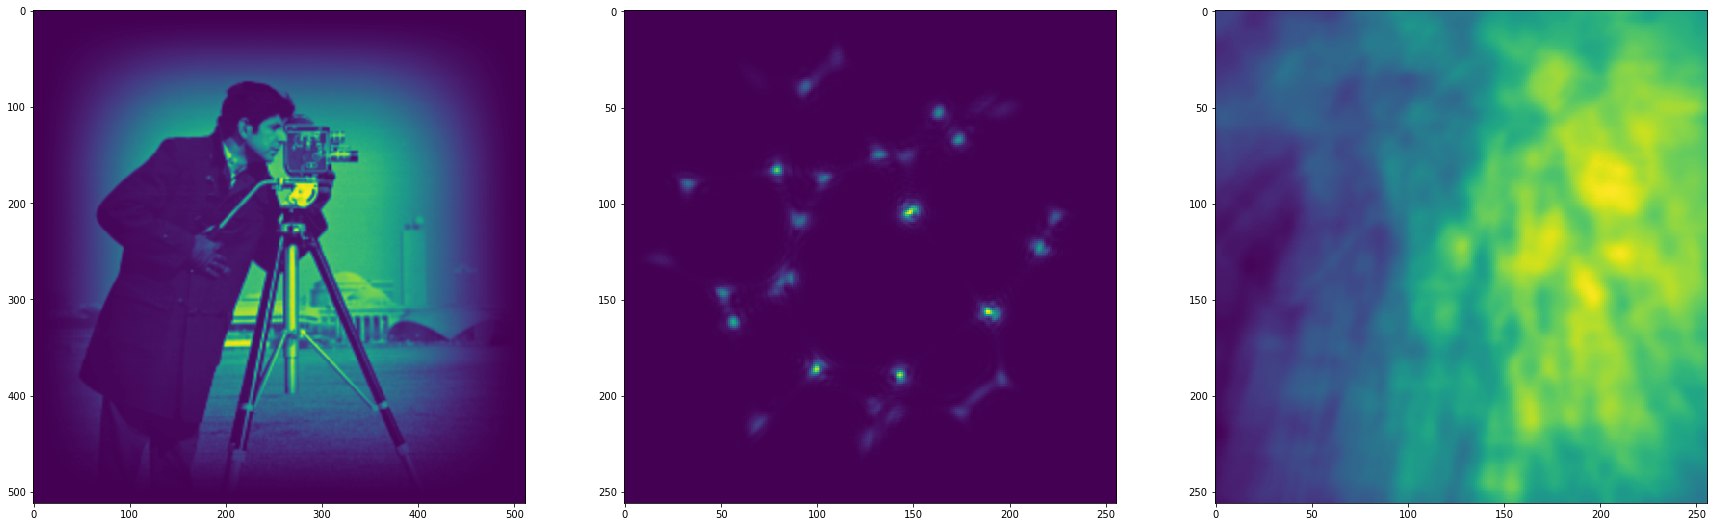

In [815]:
im_in = misc.imread('/Users/nick.antipa/GoogleDrive_berkeley/EE123_2018/Section Notes/sec3/sec3_old/cameraman.tif').astype('float')
#im_window = np.exp(-(xg**2 + yg**2)/np.sqrt(np.max(xg)/4))
im_window = np.outer(signal.windows.tukey(im_in.shape[0], .7), signal.windows.tukey(im_in.shape[1], .7))
#print(np.shape((signal.windows.tukey(im_in.shape[0]))))
im_in = im_in*im_window
im2 = imresize(im_in, tuple([2*x for x in np.shape(im_in)]))
psf_test = gen_psf_ag(ltest, 1.51, lens_f-5, 'inf', 'angle',fld,.8,550e-6, xg, yg, Fx, Fy, 0, .2)
#print(np.shape(psf_test))
psf_spect = np.fft.fft2(np.fft.ifftshift(pad_func(psf_test, 1/2)))
#print(np.shape(im2))
meas_sim  = forward_sim(psf_test, im2, crop_size = np.shape(psf_test))
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(im2)
plt.subplot(132)
plt.imshow(psf_test)
plt.subplot(133)
plt.imshow(meas_sim)

im window shape:
(512, 512)
Im in shape:
(3, 512, 512)
(256,)
(256, 256)
im2 is :
(3, 512, 512)
psf shape is:
(512, 512)
3d psf shape is:
(512, 512, 1)
psf shape is:
(512, 512)
Im shape is:
(3, 512, 512)
measurement shape is: 
(3, 256, 256)


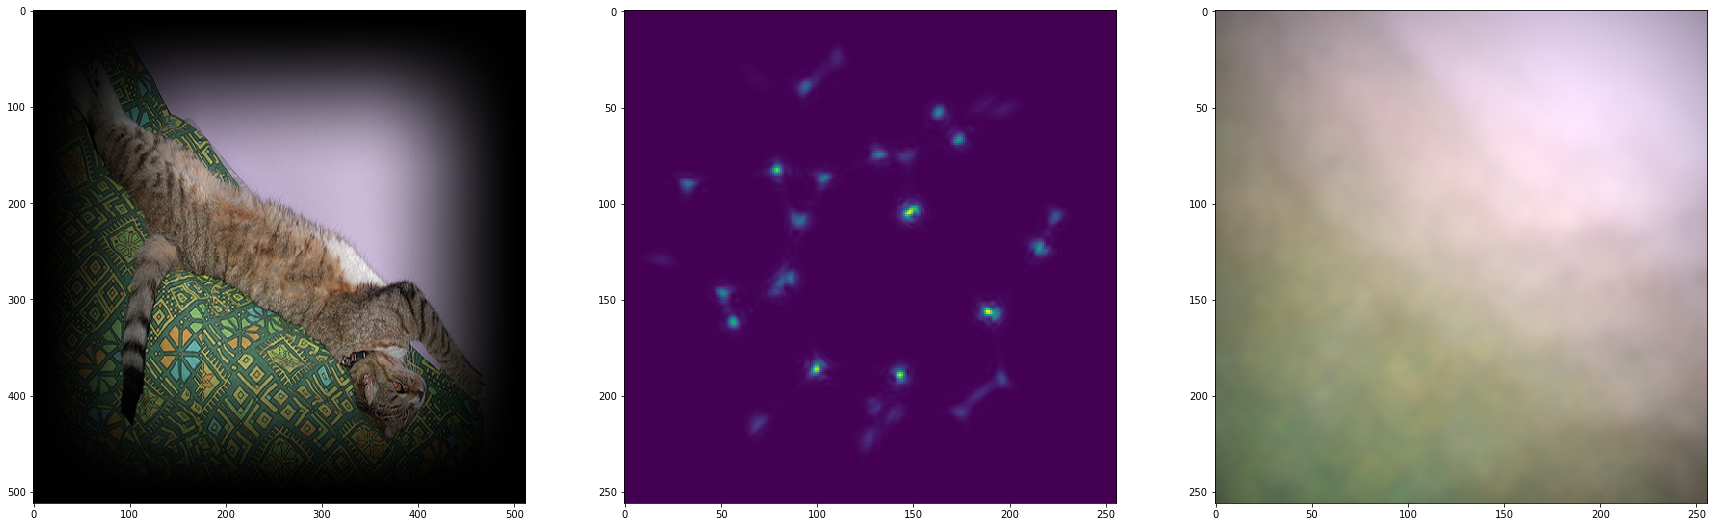

In [821]:
# Test on RGB images
im_in = train_list[1]
#im_window = np.exp(-(xg**2 + yg**2)/np.sqrt(np.max(xg)/4))
im_window = np.outer(signal.windows.tukey(im_in.shape[-2], .7), signal.windows.tukey(im_in.shape[-1], .7))
#print(np.shape((signal.windows.tukey(im_in.shape[0]))))
print("im window shape:")
print(np.shape(im_window))
im_in = im_in*np.moveaxis(np.atleast_3d(im_window), -1, 0)
print("Im in shape:")
print(np.shape(im_in))
#imresize?
print(np.shape(psf_test)[-2::-1])
print(tuple([x for x in np.shape(psf_test)]))
#im2 = [imresize(im_in[n,:,:], tuple([2*x for x in np.shape(psf_test)])) for n in range()
im2 = im_in
print("im2 is :")
print(np.shape(im2))
psf_test = gen_psf_ag(ltest, 1.51, lens_f-5, 'inf', 'angle',fld,.8,550e-6, xg, yg, Fx, Fy, 0, .2)
#print(np.shape(psf_test))
psf_spect = np.fft.fft2(np.fft.ifftshift(pad_func(psf_test, 1/2)))
print('psf shape is:')
print(np.shape(psf_spect))
print('3d psf shape is:')
print(np.shape(np.atleast_3d(psf_spect)))
#print(np.shape(im2))
meas_sim  = forward_sim(psf_test, im2, crop_size = (3,256,256))
print("measurement shape is: ")
print(np.shape(meas_sim))
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(np.moveaxis(im_in,0,-1))
#plt.imshow(im_in[1,:,:])
plt.subplot(132)
plt.imshow(psf_test)
plt.subplot(133)
plt.imshow(imnormalize(np.moveaxis(meas_sim,0,-1)))

In [817]:
def admm2d(y, psf_in, tau, niter, options = 'default'):
    #niter = 100
    #def admm_unrolled(b, psf, tau, iters):
    if options is 'default':
        options = gen_options()

    mu1 = options["mu1"]
    mu2 = options["mu2"]
    mu3 = options["mu3"]
    disp_interval = options["disp_interval"]
    resid_tol = options["resid_tol"]
    mu_inc = options["mu_inc"]
    mu_dec = options["mu_dec"]
    pad_frac = options["pad_frac"]
    if disp_interval != 0:
        fig1, ax = plt.subplots(2,3, figsize=options["fig_size"])
    Ny, Nx = psf_in.shape
    pad = lambda x:pad_func(x,pad_frac)
    crop = lambda x:crop_func(x,np.shape(im_in))
    H = np.fft.fft2(np.fft.ifftshift(pad(psf_in)))
    H_conj = np.conj(H)
    Hfor = lambda x:np.real(np.fft.ifft2(H*np.fft.fft2(x)))
    Hadj = lambda x:np.real(np.fft.ifft2(H_conj*np.fft.fft2(x)))

    Cty = pad(y)
    sk = np.zeros_like(Cty)
    alpha1k = np.zeros_like(Cty)
    alpha3k = np.zeros_like(Cty)
    alpha3kp = np.zeros_like(Cty)
    L = lambda D:(-np.diff(D,axis=0),-np.diff(D,axis=1))
    Ltv = lambda P1,P2:np.vstack([P1[0,:],np.diff(P1,axis=0),-P1[-1,:]]) + np.hstack((P2[:,[0]],np.diff(P2,axis=1),-P2[:,[-1]]))
    lapl = np.zeros_like(sk)
    lapl[0,0]=4
    lapl[0,1]=-1
    lapl[1,0]=-1
    lapl[0,-1]=-1
    lapl[-1,0]=-1
    LtL = np.abs(np.fft.fft2(lapl))
    alpha2k_1 = copy.deepcopy(sk[:-1,:])
    alpha2k_2 = copy.deepcopy(sk[:,:-1])
    HtH = np.abs(H*H_conj)
    Smult = 1/(mu1*HtH + mu2*LtL + mu3)
    CtC = pad(np.ones_like(y))
    Vmult = 1/(CtC + mu1)
    Hskp = np.zeros_like(Vmult)
    dual_resid_s = []
    primal_resid_s = []
    dual_resid_u = []
    primal_resid_u = []
    dual_resid_w = []
    primal_resid_w = []
    cost = []
    ukp_1, ukp_2 = L(np.zeros_like(y))
    Lsk1 = ukp_1
    Lsk2 = ukp_2

    for n in range(niter):

        Lsk1, Lsk2 = L(sk)

        ukp_1, ukp_2 = soft_2d_gradient(Lsk1 + alpha2k_1/mu2, Lsk2 + alpha2k_2/mu2, tau/mu2)
        #Hsk = copy.deepcopy(Hskp);   ##### DEEPCOPY!?
        Hsk = Hskp
        vkp = Vmult*(mu1*(alpha1k/mu1 + Hsk) + Cty)
        wkp = np.maximum(alpha3k/mu3 + sk, 0)
        skp_numerator = mu3*(wkp - alpha3k/mu3) + mu2*Ltv(ukp_1 - alpha2k_1/mu2, ukp_2 - alpha2k_2/mu2) + mu1 * Hadj(vkp - alpha1k/mu1)
        skp = np.real(np.fft.ifft2(Smult * np.fft.fft2(skp_numerator)))

        Hskp = Hfor(skp)
        r_sv = Hskp - vkp
        dual_resid_s.append(mu1 * np.linalg.norm(Hsk - Hskp,'fro'))
        primal_resid_s.append(np.linalg.norm(r_sv,'fro'))

        mu1, mu1_update = update_param(mu1, resid_tol, mu_inc, mu_dec, primal_resid_s[-1], dual_resid_s[-1])
        alpha1k += mu1*r_sv

        Lskp1, Lskp2 = L(skp)
        r_su_1 = Lskp1 - ukp_1
        r_su_2 = Lskp2 - ukp_2
        dual_resid_u.append(mu2*np.sqrt(np.linalg.norm(Lsk1 - Lskp1,'fro')**2 + np.linalg.norm(Lsk2 - Lskp2,'fro')**2))
        primal_resid_u.append(np.sqrt(np.linalg.norm(r_su_1,'fro')**2 + np.linalg.norm(r_su_2,'fro')**2))


        mu2, mu2_update = update_param(mu2, resid_tol, mu_inc, mu_dec, primal_resid_u[-1], dual_resid_u[-1])
        alpha2k_1+= mu2*r_su_1
        alpha2k_2+= mu2*r_su_2


        r_sw = skp - wkp
        dual_resid_w.append(mu3*np.linalg.norm(sk - skp,'fro'))
        primal_resid_w.append(np.linalg.norm(r_sw,'fro'))

        mu3, mu3_update = update_param(mu3, resid_tol, mu_inc, mu_dec, primal_resid_w[-1], dual_resid_w[-1])
        alpha3k += mu3*r_sw

        mu_update = 0
        if mu1_update or mu2_update or mu3_update:
            mu_update = 1
            Smult = 1/(mu1*HtH + mu2*LtL + mu3)
            Vmult = 1/(CtC + mu1)

        sk = skp;
        cost.append(np.linalg.norm(crop(Hskp)-y,'fro')**2 + tau*TVnorm(skp))
        if disp_interval != 0:
            if n % disp_interval == 0: 


                ax[0,0].imshow(sk)
                ax[0,0].set_title('cost. Mu update: {}'.format(mu_update))


                ax[0,1].semilogy(cost)
                ax[0,1].set_title('cost')
                
                ax[0,2].semilogy(dual_resid_s)
                ax[0,2].semilogy(primal_resid_s)
                ax[0,2].set_title('crop (s) residuals, mu1 = %.2f' %mu1)

                ax[1,0].semilogy(dual_resid_u)
                ax[1,0].semilogy(primal_resid_u)
                ax[1,0].set_title('TV (u) residuals, mu2 = %.2f'  % mu2)

                ax[1,1].semilogy(dual_resid_w)
                ax[1,1].semilogy(primal_resid_w)
                ax[1,1].set_title('Nonnegativity (w) residuals, mu3 = %.2f'  % mu3)

                ax[1,2].imshow(psf_in)
                ax[1,2].set_title('psf')

                display.display(fig1)
                display.clear_output(wait=True)
    return sk
        
        

    
def soft_2d_gradient(v,h,tau):

    mag = np.sqrt(np.vstack([v,np.zeros((1,v.shape[1]))])**2 + np.hstack((h,np.zeros((h.shape[0],1))))**2)
    magt = np.maximum(mag - tau,0)
    mag = np.maximum(mag - tau, 0) + tau
    mmult = magt/mag
    #mmult[mag==0] = 0
    return v*mmult[:-1,:], h*mmult[:,:-1]

def update_param(mu, resid_tol, mu_inc, mu_dec, r, s):
    if r > resid_tol * s:
        mu_out = mu*mu_inc
        mu_update = 1
    elif r*resid_tol < s:
        mu_out = mu/mu_dec
        mu_update = -1
    else:
        mu_out = mu
        mu_update = 0
    return mu_out, mu_update

def TVnorm(x):
    result = 0
    for n in range(x.ndim):
        result += np.sum(np.abs(np.diff(x,axis=n)))
    return result

def gen_options(mu1 = .8, mu2 = .22, mu3 = .25, disp_interval = 0, resid_tol = 1.5, mu_inc = 1.2, mu_dec = 1.2, pad_frac = 1/2, fig_size = plt.rcParams.get('figure.figsize')):
    out = {
        "mu1" : mu1,
        "mu2" : mu2,
        "mu3" : mu3,
        "disp_interval" : disp_interval,
        "resid_tol" : resid_tol,
        "mu_inc" : mu_inc,
        "mu_dec" : mu_dec,
        "pad_frac" : pad_frac,
        "fig_size" : fig_size
    }
    return out
    
    
    
    
    

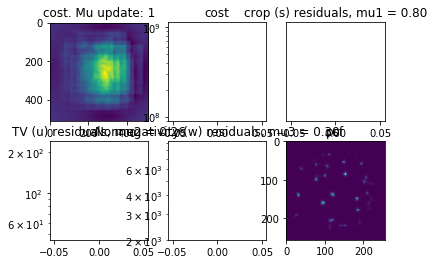

In [15]:
reconned = admm2d(meas_sim, psf_test, 1, 10, gen_options(disp_interval = 10))
#plt.figure()
#plt.imshow(reconned)

In [16]:
def singlet_loss_admm(R_lens, prop_distance, lens_ior, iters, im_gt):
    global resid_im_single
    global recon_single
    surface_single = make_lens_surface_ag(R_lens, xg, yg)
    psf_single = gen_psf_ag(surface_single, lens_ior, prop_distance, 'inf', 'angle', (0,0), .9, 550e-6, xg, yg, Fx, Fy, 0, .2)
    meas_single = forward_sim(psf_single, im_gt)
    recon_single = admm2d(meas_single, psf_single, 1, iters)
    resid_im_single = crop_func(recon_single - im_gt, tuple((int(im_gt.shape[0]//2), int(im_gt.shape[1]//2))))
    loss_out = np.linalg.norm(resid_im_single)
    return loss_out

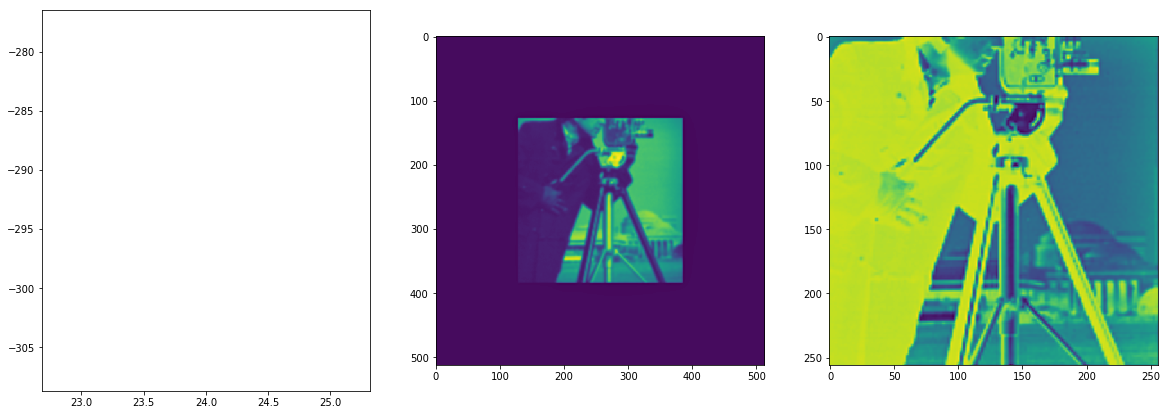

In [17]:
#Forward pass:
# surface = f(x_list, y_list, r_list)
# psf = f(surface)
# meas = f(psf, im)
# recon = f(psf, meas)
# loss = f(meas)
#def im_loss_admm2d()
im_single = im2


ior_single = 1.51
target_rad = 2*lens_rad
f_single = target_rad/(ior_single-1)
print(target_rad)
print(f_single)
loss_single = []
fig_single, ax_single = plt.subplots(1,3, figsize = (20,7))
R_list_single = np.linspace(target_rad, target_rad+200, 1)
grad_single = value_and_grad(singlet_loss_admm)
vals = []
grad_vals = []
ims = []
#imax1 = ax_single[1].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
#imax2 = ax_single[2].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
imlist = []
for R_single in R_list_single:
    #v = singlet_loss_admm(R_single, f_single, ior_single, 3, im_single)
    v, g = grad_single(R_single, f_single, ior_single, 1, im_single)
    vals.append(v)
    grad_vals.append(g)
    plot1, = ax_single[0].plot(R_list_single[:len(vals)], grad_vals, 'b')
    implot1 = ax_single[1].imshow(recon_single._value, animated = True)
    imlist.append(recon_single._value)
    implot2 = ax_single[2].imshow(resid_im_single._value, animated = True)
    display.display(fig_single)
    display.clear_output(wait=True)
    ims.append([plot1, implot1, implot2])

In [18]:
# fig, ax = plt.subplots(1,3,figsize=(20,10))
# im_window2 = np.outer(signal.windows.tukey(im2.shape[0], .8), signal.windows.tukey(im2.shape[1], .2))
# loss_crop = []
# #plt.imshow(im_window2)
# resid_image1 = np.abs((crop_func(imlist[0], np.shape(im2)) - crop_func(im2, np.shape(im2)))/(im2+1))**2
# resid_image2 = np.abs((crop_func(imlist[6], np.shape(im2)) - crop_func(im2, np.shape(im2)))/(im2+1))**2
# imhandle1 = ax[0].imshow(resid_image1, vmax = np.max(resid_image1))
# ax[2].plot(im_in[-1,:])
# ax[2].plot(im_in[-2,:])
# print("Out of focus cost: %.2f" %np.sum(resid_image1))
# print("In focus cost: %.2f" %np.sum(resid_image2))
# imhandle2 = ax[1].imshow(resid_image2, vmax = np.max(resid_image1))

#plt.colorbar(imhandle2)
#print(np.sum(np.abs(crop_func(imlist[6], np.shape(im2)) - crop_func(im2, np.shape(im2)))**2))

# for n in range(len(imlist)):
#     loss_crop.append(np.linalg.norm(im_window2*(crop_func(imlist[n], np.shape(im2)) - crop_func(im2, np.shape(im2)))))
#     plt.plot(loss_crop)
#     display.display(fig)
#     display.clear_output(wait = True)

In [ ]:
ani = animation.ArtistAnimation(fig_single, ims, interval=500, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())
#ani.save('./lens_focus_ADMM_AG_2norm.mp4',writer = 'ffmpeg', fps=5)

In [ ]:
# admmiters = 1
# R_learned = GD_nesterov(grad_single, 50, 1e-12)

/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)


KeyboardInterrupt: 

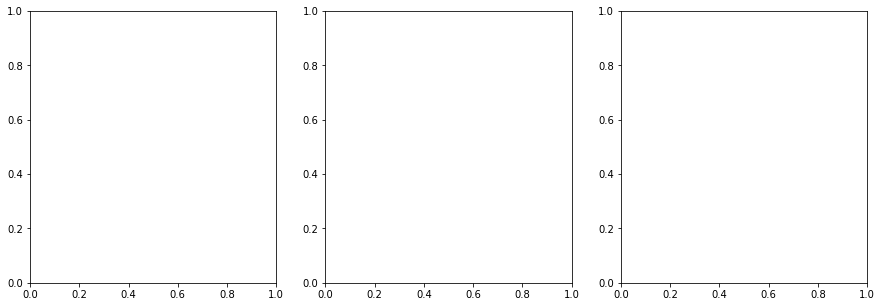

In [19]:
# Let's do gradient descent!
grad_single = value_and_grad(singlet_loss_admm)
#def GD_nesterov(grad_func, iters, step_size):
R_singlek = 31.
#global display_container
display_container = []
GDiters = 50
v = []
g = []
grad_vals = []
vals = []
t = 1
step_size = .2e-3
R_learned_list = []

fig_learned, ax_learned = plt.subplots(1,3,figsize=(15,5))
for n in range(GDiters):
    #v, g = grad_single(R_single, f_single, ior_single, admmiters, im_single)
    v, g = grad_single(R_singlek, f_single, ior_single, 20, im_single)
    R_singlep = R_singlek - step_size * g
    
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
    
    R_single = R_singlep + beta*(R_singlep - R_single)
    
    vals.append(v)
    grad_vals.append(g)
    R_learned_list.append(R_single)
    
    
    if n > 3:
        if v>vals[-2]:
            t = 1
        else:
            t = tp
    plot1, = ax_learned[0].plot(vals, 'b')
    implot1 = ax_learned[1].imshow(recon_single._value, animated = True)
    titax = ax_learned[1].text(0.5,1.05,"Radius: %.2f" %R_singlek, 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax_learned[1].transAxes,)
    titax.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
    R_singlek = R_single
    imlist.append(recon_single._value)
    implot2 = ax_learned[2].imshow(resid_im_single._value, animated = True)
    display.display(fig_learned)
    display.clear_output(wait=True)
    display_container.append([plot1, implot1, implot2, titax])


In [ ]:
ani = animation.ArtistAnimation(fig_learned, display_container, interval=200, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

1424032.5251285597
1424032.5251285597
2848088.8
(10, 512, 512, 3)


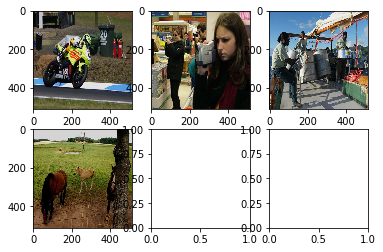

In [139]:
# Now let's try SGD
# Setup training data


dataset_dir = '/Users/nick.antipa/Documents/TrainingData/NaturalImages512/'
imfiles = [f for f in listdir(dataset_dir) if isfile(join(dataset_dir, f))]

Nfiles = len(imfiles)
Ntrain = 10
Nbatch = 6
Nval = 5
train_inds = np.random.choice(Nfiles, Ntrain, replace=False)


train_files = [imfiles[n] for n in train_inds]

# Remove training images
[imfiles.pop(n) for n in sorted(train_inds, reverse=True)]

val_inds = np.random.choice(Nfiles-Ntrain, Nval, replace=False)
val_files = [imfiles[n] for n in val_inds]

# Load training list
train_list = []
[train_list.append(imnormalize(misc.imread(dataset_dir+train_files[n]).astype('float32'))) for n in range(Ntrain)]

val_list = []
imnormalize = lambda x:x/np.max(x)
[val_list.append(imnormalize(misc.imread(dataset_dir+val_files[n]).astype('float32'))) for n in range(Nval)]

subrows = int(np.floor(np.sqrt(Nval)))
subcols = int(np.ceil(np.sqrt(Nval)))
fig, ax = plt.subplots(subrows, subcols)#, figsize=(20,20))
c =0
for n in range(subrows):
    for m in range(subcols):
        c+=1
        if c < Nval:
            ax[n,m].imshow(val_list[c])
        

        
losstest, outtest = sgdtest(1., 1, 1, 10, train_list, Ntrain)
print(outtest['loss'])

lossgradtest = grad_and_aux(sgdtest)

g, gtest = lossgradtest(1., 1, 1, 10, train_list, Ntrain)
print(gtest['loss']._value)
print(g)
print(np.shape(outtest['resid_ims']))




In [156]:
# Test RGB reconf
meas_test = forward_sim(psf_test,val_list[0])

ValueError: operands could not be broadcast together with shapes (512,512) (512,512,3) 

In [ ]:
meas_test = forward_sim

In [ ]:
def sgdtest(R_lens, prop_distance, lens_ior, iters, im_list, batch_size):
    # SGD for autograd, for use with grad_and_aux
    #surface_single = make_lens_surface_ag(R_lens, xg, yg)
    #psf_single = gen_psf_ag(surface_single, lens_ior, prop_distance, 'inf', 'angle', (0,0), .9, 550e-6, xg, yg, Fx, Fy, 0, .2)
    #meas_single = [None]*batch_size
    #recon_single = [None]*batch_size
    loss_list = []
    iminds = np.random.choice(len(im_list), batch_size, replace=False)
    resid_im_single = []
    for n in iminds:
        #meas_single[n] = forward_sim(psf_single, im_list[n])
        #recon_single[n] = admm2d(meas_single[n], psf_single, 1, iters)
        #resid_im_single = crop_func(recon_single[n] - im_list[n], tuple((int(im_list[n].shape[0]//2), int(im_list[n].shape[1]//2))))
        recon_rgb = []
        resid_im_single.append(im_list[n])
        loss_list.append(0.5 * np.linalg.norm(R_lens*resid_im_single[-1].ravel())**2)
        
    loss_out = np.sum(loss_list)
    out_dict = {
        'loss' : loss_out,
        'resid_ims' : resid_im_single
    }
    return loss_out, out_dict

In [137]:
elementwise_grad?
#ani.save('./lens_focus_ADMM_AG_Nesterov_2norm_crop1.mp4',writer = 'ffmpeg', fps=5)

In [61]:
def lenslet_loss_admm(R_lenslet_learning, x_list_learning, y_list_learning, prop_distance, lens_ior, iters, im_gt):
    # make_lenslet_surface_ag(Xlist, Ylist, Rlist, xg, yg, offset):
    global resid_im_lenslets
    global recon_lenslets
    global loss_lenslets
    global psf_lenslets
    global meas_lenslets
    surface_lenslets = make_lenslet_surface_ag(x_list_learning, y_list_learning, R_lenslet_learning, xg, yg, 10)
    psf_lenslets = gen_psf_ag(surface_lenslets, lens_ior, prop_distance, 'inf', 'angle', (0,0), .9, 550e-6, xg, yg, Fx, Fy, 0, .2)
    meas_lenslets = forward_sim(psf_lenslets, im_gt)
    recon_lenslets = admm2d(meas_lenslets, psf_lenslets, .1, iters)
    resid_im_lenslets = crop_func(recon_lenslets - im_gt, tuple((int(im_gt.shape[0]//2), int(im_gt.shape[1]//2))))
    loss_lenslets = np.linalg.norm(resid_im_lenslets)
    return loss_lenslets

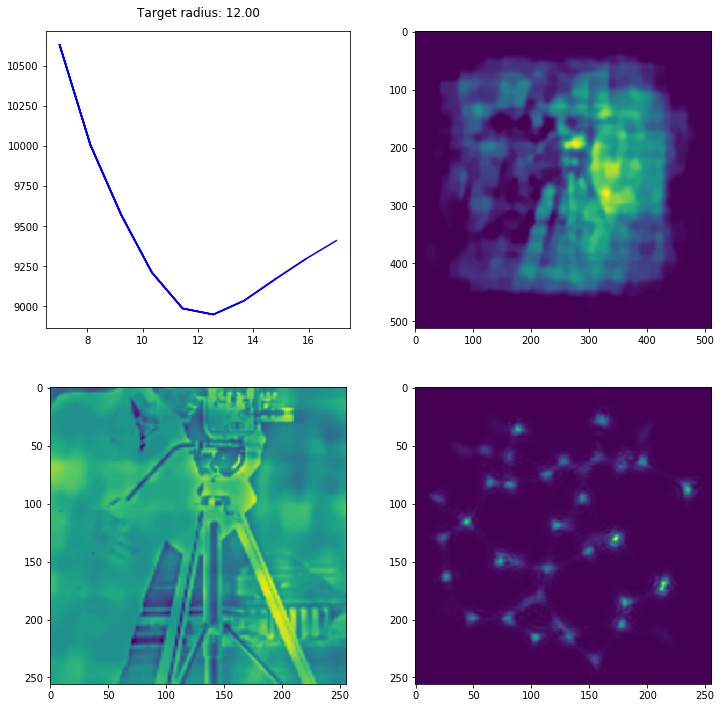

In [30]:
im_lenslets = im2


ior_lenslets = 1.51
target_rad_lenslets = lens_rad
f_lenslets = target_rad_lenslets/(ior_lenslets-1)
print(target_rad)
print(f_lenslets)
fig_single, ax_single = plt.subplots(2,2, figsize = (12,12))
R_list_lenslets = np.linspace(target_rad_lenslets-5, target_rad_lenslets+5, 10)
grad_lenslets = elementwise_grad(lenslet_loss_admm)
vals = []
grad_vals = []
ims = []
x_list_init = np.random.rand(50)*1.8-.9
y_list_init = np.random.rand(50)*1.8-.9
good_lenslets = np.sqrt(x_list_init**2+y_list_init**2) < 1
x_list_learn = copy.deepcopy(x_list_init[good_lenslets])
y_list_learn = copy.deepcopy(y_list_init[good_lenslets])


#imax1 = ax_single[1].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
#imax2 = ax_single[2].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
imlist = []
for R_lenslets in R_list_lenslets:
    #v = singlet_loss_admm(R_single, f_lenslets, ior_lenslets, 3, im_lenslets)
    g = grad_lenslets(R_lenslets, x_list_learn, y_list_learn, f_lenslets, ior_lenslets, 40, im_lenslets)
    #a = lenslet_loss_admm(np.array([R_lenslets]), x_list_init, y_list_init, f_lenslets, ior_lenslets, 1, im_lenslets)
    vals.append(loss_lenslets._value)
    grad_vals.append(g)
    plot1, = ax_single[0,0].plot(R_list_lenslets[:len(vals)], vals, 'b')
    titax = ax_single[0,0].text(0.5,1.05,"Target radius: %.2f" %target_rad_lenslets, 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax_single[0,0].transAxes,)
    titax.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
    implot1 = ax_single[0,1].imshow(recon_lenslets._value, animated = True)
    imlist.append(recon_single._value)
    implot2 = ax_single[1,0].imshow(resid_im_lenslets._value, animated = True)
    psfplot = ax_single[1,1].imshow(psf_lenslets._value, animated = True)
    display.display(fig_single)
    display.clear_output(wait=True)
    ims.append([plot1, implot1, implot2, psfplot, titax])

In [ ]:
ani = animation.ArtistAnimation(fig_single, ims, interval=500, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

In [34]:
#ani.save('../lenslets_focus_sweep_ADMM.mp4',writer = 'ffmpeg', fps=5)

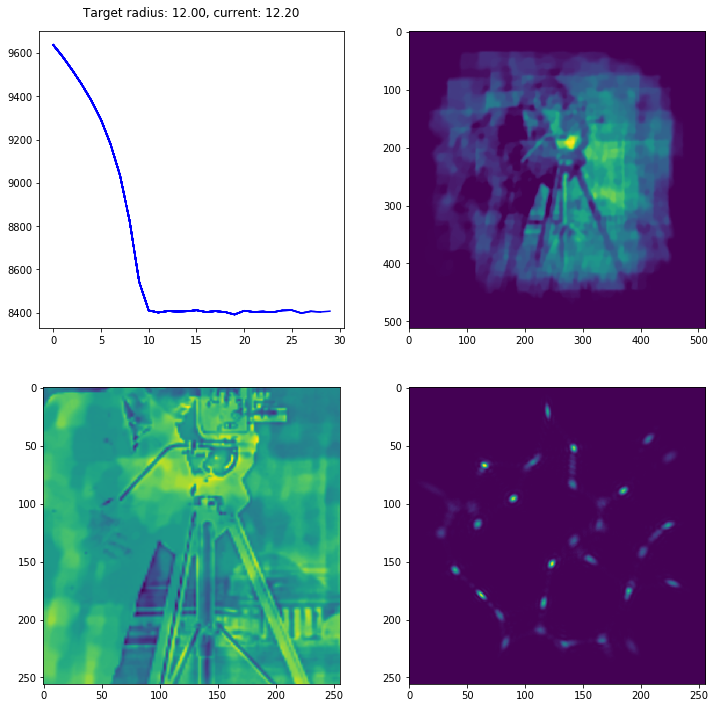

In [45]:
im_lenslets = im2


ior_lenslets = 1.51
target_rad_lenslets = lens_rad
f_lenslets = target_rad_lenslets/(ior_lenslets-1)
print(target_rad)
print(f_lenslets)
fig_single, ax_single = plt.subplots(2,2, figsize = (12,12))
R_list_lenslets = np.linspace(target_rad_lenslets-5, target_rad_lenslets+5, 10)
grad_lenslets = elementwise_grad(lenslet_loss_admm)
vals = []
grad_vals = []
ims = []
x_list_init = np.random.rand(50)*1.8-.9
y_list_init = np.random.rand(50)*1.8-.9
good_lenslets = np.sqrt(x_list_init**2+y_list_init**2) < 1
x_list_learn = copy.deepcopy(x_list_init[good_lenslets])
y_list_learn = copy.deepcopy(y_list_init[good_lenslets])
N_lenslets_learning = len(x_list_init)


#imax1 = ax_single[1].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
#imax2 = ax_single[2].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
imlist = []
niters_lenslets = 30
R_lensletsk = 25.
R_learned_list_lenslets = []
step_size_lenslets = .7e-2
for n in range(niters_lenslets):
    #v = singlet_loss_admm(R_single, f_lenslets, ior_lenslets, 3, im_lenslets)
    g = grad_lenslets(R_lensletsk, x_list_learn, y_list_learn, f_lenslets, ior_lenslets, 50, im_lenslets)
    #a = lenslet_loss_admm(np.array([R_lenslets]), x_list_init, y_list_init, f_lenslets, ior_lenslets, 1, im_lenslets)
    vals.append(loss_lenslets._value)
    
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
    R_lensletsp = R_lensletsk - step_size_lenslets * g
    R_lenslets = R_lensletsp + beta*(R_lensletsp - R_lensletsk)
    R_learned_list_lenslets.append(R_lenslets)
    
    grad_vals.append(g)
    
    
    
    if n > 3:
        if v>vals[-2]:
            t = 1
        else:
            t = tp
            
    
    
    
    plot1, = ax_single[0,0].plot(vals, 'b')
    titax = ax_single[0,0].text(0.5,1.05,"Target radius: %.2f, current: %.2f" %(target_rad_lenslets, R_lensletsk), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax_single[0,0].transAxes,)
    titax.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
    implot1 = ax_single[0,1].imshow(recon_lenslets._value, animated = True)
    imlist.append(recon_single._value)
    implot2 = ax_single[1,0].imshow(resid_im_lenslets._value, animated = True)
    psfplot = ax_single[1,1].imshow(psf_lenslets._value, animated = True)
    display.display(fig_single)
    display.clear_output(wait=True)
    ims.append([plot1, implot1, implot2, psfplot, titax])
    
    R_lensletsk = R_lenslets

In [ ]:
ani = animation.ArtistAnimation(fig_single, ims, interval=100, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

In [47]:
#ani.save('./lenslets_focus_ADMM_AG_Nesterov_2norm_crop1.mp4',writer = 'ffmpeg', fps=5)

In [53]:
Nlenslets_learning = len(x_list_init)
R_vec = np.random.rand(Nlenslets_learning) + 12
gtest = grad_lenslets(R_vec, x_list_learn, y_list_learn, f_lenslets, ior_lenslets, 1, im_lenslets)
print(gtest)

[ 0.04292216  0.60385442 -4.14660965  0.53981223  3.34348675 -0.342018
  1.7174421  -0.10141351  1.59286057 -0.12588932  1.41616816 -3.71974762
  0.34969093 -2.80052547 -0.04697982  0.27099472  1.65087668  3.07161819
  0.          0.77661447  1.05717116  0.97437901  0.14950507  0.79999199
  0.15661597  1.19736758 -0.15962625  1.22950752  2.26249987  0.16102405
  0.93628285 -1.79446859 -2.37679175 -0.16709101 -0.22634144  0.04751035
 -0.43689929  0.57008693  0.57571055 -0.33392388  0.87681539 -4.778183
 -0.3513566   0.          0.          0.          0.          0.
  0.          0.        ]


24.0
23.52941176470588


/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


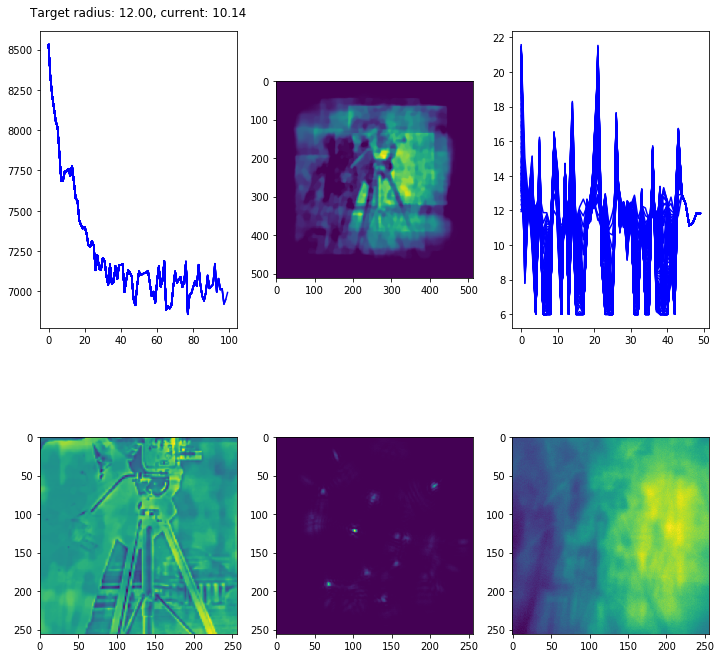

In [89]:
im_lenslets = im2


ior_lenslets = 1.51
target_rad_lenslets = lens_rad
f_lenslets = target_rad_lenslets/(ior_lenslets-1)
print(target_rad)
print(f_lenslets)
fig_single, ax_single = plt.subplots(2,3, figsize = (12,12))
R_list_lenslets = np.linspace(target_rad_lenslets-5, target_rad_lenslets+5, 10)
grad_lenslets = elementwise_grad(lenslet_loss_admm)
vals = []
grad_vals = []
ims = []
x_list_init = np.random.rand(50)*1.8-.9
y_list_init = np.random.rand(50)*1.8-.9
good_lenslets = np.sqrt(x_list_init**2+y_list_init**2) < 1
x_list_learn = copy.deepcopy(x_list_init[good_lenslets])
y_list_learn = copy.deepcopy(y_list_init[good_lenslets])
N_lenslets_learning = len(x_list_init)


#imax1 = ax_single[1].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
#imax2 = ax_single[2].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
imlist = []
niters_lenslets = 100
R_lensletsk = np.random.rand(Nlenslets_learning)*2 + 11.
R_learned_list_lenslets = []
step_size_lenslets = .5e-2
for n in range(niters_lenslets):
    #v = singlet_loss_admm(R_single, f_lenslets, ior_lenslets, 3, im_lenslets)
    g = grad_lenslets(R_lensletsk, x_list_learn, y_list_learn, f_lenslets, ior_lenslets, 50, im_lenslets)
    #a = lenslet_loss_admm(np.array([R_lenslets]), x_list_init, y_list_init, f_lenslets, ior_lenslets, 1, im_lenslets)
    vals.append(loss_lenslets._value)
    
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
    R_lensletsp = R_lensletsk - step_size_lenslets * g
    R_lenslets = R_lensletsp + beta*(R_lensletsp - R_lensletsk)
    R_learned_list_lenslets.append(R_lenslets)
    R_lenslets = np.maximum(R_lenslets, 6)
    
    grad_vals.append(g)
    
    
    
    if n > 3:
        if v>vals[-2]:
            t = 1
        else:
            t = tp
            
    
    
    
    plot1, = ax_single[0,0].plot(vals, 'b')
    titax = ax_single[0,0].text(0.5,1.05,"Target radius: %.2f, current: %.2f" %(target_rad_lenslets, np.mean(R_lensletsk)), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax_single[0,0].transAxes,)
    titax.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
    
    plot2, = ax_single[0,2].plot(R_lensletsk, 'b')
    
    implot1 = ax_single[0,1].imshow(recon_lenslets._value, animated = True)
    imlist.append(recon_single._value)
    implot2 = ax_single[1,0].imshow(resid_im_lenslets._value, animated = True)
    psfplot = ax_single[1,1].imshow(psf_lenslets._value, animated = True)
    measplot = ax_single[1,2].imshow(meas_lenslets._value, animated = True)
    #display.display(fig_single)
    #display.clear_output(wait=True)
    ims.append([plot1, plot2, implot1, implot2, psfplot, titax, measplot])
    
    R_lensletsk = R_lenslets

In [134]:
ani = animation.ArtistAnimation(fig_single, ims, interval=33, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

In [91]:
#ani.save('./lenslets_focus_vec_ADMM_50reconiter_12init.mp4',writer = 'ffmpeg', fps=5)

24.0
23.52941176470588


/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: divide by zero encountered in power
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:97: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)


Iter 0, cost 1.02e+04
Iter 1, cost 9.80e+03
Iter 2, cost 9.17e+03
Iter 3, cost 8.58e+03
Iter 4, cost 8.22e+03


/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Iter 5, cost 8.01e+03
Iter 6, cost 7.86e+03
Iter 7, cost 7.75e+03
Iter 8, cost 7.64e+03
Iter 9, cost 7.54e+03
Iter 10, cost 7.45e+03
Iter 11, cost 7.38e+03
Iter 12, cost 7.30e+03
Iter 13, cost 7.24e+03
Iter 14, cost 7.19e+03
Iter 15, cost 7.13e+03
Iter 16, cost 7.08e+03
Iter 17, cost 7.04e+03
Iter 18, cost 7.01e+03
Iter 19, cost 6.97e+03
Iter 20, cost 6.94e+03
Iter 21, cost 6.91e+03
Iter 22, cost 6.88e+03
Iter 23, cost 6.87e+03
Iter 24, cost 6.84e+03
Iter 25, cost 6.82e+03
Iter 26, cost 6.81e+03
Iter 27, cost 6.78e+03
Iter 28, cost 6.78e+03
Iter 29, cost 6.75e+03
Iter 30, cost 6.75e+03
Iter 31, cost 6.71e+03
Iter 32, cost 6.70e+03
Iter 33, cost 6.70e+03
Iter 34, cost 6.70e+03
Iter 35, cost 6.69e+03
Iter 36, cost 6.67e+03
Iter 37, cost 6.66e+03
Iter 38, cost 6.65e+03
Iter 39, cost 6.63e+03
Iter 40, cost 6.60e+03
Iter 41, cost 6.60e+03
Iter 42, cost 6.57e+03
Iter 43, cost 6.57e+03
Iter 44, cost 6.56e+03
Iter 45, cost 6.54e+03
Iter 46, cost 6.54e+03
Iter 47, cost 6.53e+03
Iter 48, cost 6.

Iter 351, cost 5.64e+03
Iter 352, cost 5.65e+03
Iter 353, cost 5.65e+03
Iter 354, cost 5.64e+03
Iter 355, cost 5.65e+03
Iter 356, cost 5.64e+03
Iter 357, cost 5.63e+03
Iter 358, cost 5.64e+03
Iter 359, cost 5.63e+03
Iter 360, cost 5.63e+03
Iter 361, cost 5.63e+03
Iter 362, cost 5.63e+03
Iter 363, cost 5.64e+03
Iter 364, cost 5.63e+03
Iter 365, cost 5.64e+03
Iter 366, cost 5.63e+03
Iter 367, cost 5.63e+03
Iter 368, cost 5.62e+03
Iter 369, cost 5.62e+03
Iter 370, cost 5.63e+03
Iter 371, cost 5.63e+03
Iter 372, cost 5.63e+03
Iter 373, cost 5.62e+03
Iter 374, cost 5.63e+03
Iter 375, cost 5.62e+03
Iter 376, cost 5.63e+03
Iter 377, cost 5.62e+03
Iter 378, cost 5.62e+03
Iter 379, cost 5.62e+03
Iter 380, cost 5.62e+03
Iter 381, cost 5.62e+03
Iter 382, cost 5.62e+03
Iter 383, cost 5.61e+03
Iter 384, cost 5.61e+03
Iter 385, cost 5.62e+03
Iter 386, cost 5.61e+03
Iter 387, cost 5.61e+03
Iter 388, cost 5.60e+03
Iter 389, cost 5.62e+03
Iter 390, cost 5.62e+03
Iter 391, cost 5.60e+03
Iter 392, cost 5

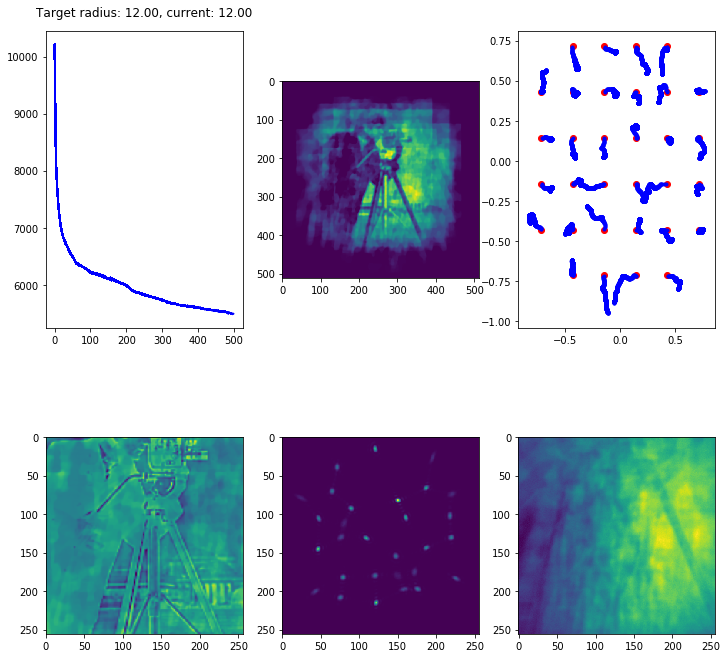

In [182]:
im_lenslets = im2


ior_lenslets = 1.51
target_rad_lenslets = lens_rad
f_lenslets = target_rad_lenslets/(ior_lenslets-1)
print(target_rad)
print(f_lenslets)
fig_single, ax_single = plt.subplots(2,3, figsize = (12,12))
R_list_lenslets = np.linspace(target_rad_lenslets-5, target_rad_lenslets+5, 10)
grad_lenslets = elementwise_grad(lenslet_loss_admm,argnum = (1,2))
vals = []
grad_vals = []
ims = []
#x_list_init = np.random.rand(50)*1.8-.9
#y_list_init = np.random.rand(50)*1.8-.9
xi = np.linspace(-1,1,8)
yi = np.linspace(-1,1,8)
x_list_grid, y_list_grid = np.meshgrid(xi,yi)
x_list_init = x_list_grid.ravel()
y_list_init = y_list_grid.ravel()
good_lenslets = np.sqrt(x_list_init**2+y_list_init**2) < 1
x_learn = copy.deepcopy(x_list_init[good_lenslets])
y_learn = copy.deepcopy(y_list_init[good_lenslets])
x_learnk = x_learn
y_learnk = y_learn
N_lenslets_learning = len(x_list_init)


#imax1 = ax_single[1].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
#imax2 = ax_single[2].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
imlist = []
niters_lenslets = 500
R_lensletsk = np.random.rand(Nlenslets_learning)*0 + 12.

R_learned_list_lenslets = []
step_size_lenslets = .5e-2
step_size_x = .1e-5
step_size_y = step_size_x
x_learned_list = []
y_learned_list = []
plot3 = ax_single[0,2].scatter(x_learn, y_learn, c='r')

for n in range(niters_lenslets):
    #v = singlet_loss_admm(R_single, f_lenslets, ior_lenslets, 3, im_lenslets)
    gx, gy = grad_lenslets(R_lensletsk, x_learn, y_learn, f_lenslets, ior_lenslets, 50, im_lenslets)
    #a = lenslet_loss_admm(np.array([R_lenslets]), x_list_init, y_list_init, f_lenslets, ior_lenslets, 1, im_lenslets)
    vals.append(loss_lenslets._value)
    
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
#     R_lensletsp = R_lensletsk - step_size_lenslets * g
#     R_lenslets = R_lensletsp + beta*(R_lensletsp - R_lensletsk)
#     R_learned_list_lenslets.append(R_lenslets)
#     R_lenslets = np.maximum(R_lenslets, 6)
    
    x_learnp = x_learn - step_size_x * gx
    x_learn = x_learnp + beta*(x_learnp - x_learnk)

    
    y_learnp = y_learn - step_size_y * gy
    y_learn = y_learnp + beta*(y_learnp - y_learnk)
    
    #Project back onto aperture
    lr = np.sqrt(y_learn**2 + x_learn**2)
    lr = np.minimum(lr, ca+.1)
    ya = np.arctan2(y_learn, x_learn)
    y_learn = lr * np.sin(ya)
    x_learn = lr * np.cos(ya)
    
    x_learned_list.append(x_learn)
    y_learned_list.append(y_learn)
    
    print("Iter %i, cost %.2e" %(n,loss_lenslets._value))
    
    
    #grad_vals.append(g)
    
    
    
    if n > 3:
        if v>(1.5*vals[-2]):
            t = 1
        else:
            t = tp
            
    
    
    plot1, = ax_single[0,0].plot(vals, 'b')
    titax = ax_single[0,0].text(0.5,1.05,"Target radius: %.2f, current: %.2f" %(target_rad_lenslets, np.mean(R_lensletsk)), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax_single[0,0].transAxes,)
    titax.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
    
    plot2 = ax_single[0,2].scatter(x_learn, y_learn, c = 'b', marker='.')#ax_single[0,2].plot(R_lensletsk, 'b')
    #plot2.set_offsets(x_learn, y_learn)
    implot1 = ax_single[0,1].imshow(recon_lenslets._value, animated = True)
    imlist.append(recon_lenslets._value)
    implot2 = ax_single[1,0].imshow(resid_im_lenslets._value, animated = True)
    psfplot = ax_single[1,1].imshow(psf_lenslets._value, animated = True)
    measplot = ax_single[1,2].imshow(meas_lenslets._value, animated = True)
    #display.display(fig_single)
    #display.clear_output(wait=True)
    ims.append([plot1, plot2, implot1, implot2, psfplot, titax, measplot, plot3])
    
    #R_lensletsk = R_lenslets
    x_learnk = x_learn
    y_learnk = y_learn

In [184]:
ani = animation.ArtistAnimation(fig_single, ims, interval=10, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

In [186]:
ani.save('../locations_50reconiter_goodstep_500epochs_uniformInit_60fps.mp4',writer = 'ffmpeg', fps=60)

(-0.5, 511.5, 511.5, -0.5)

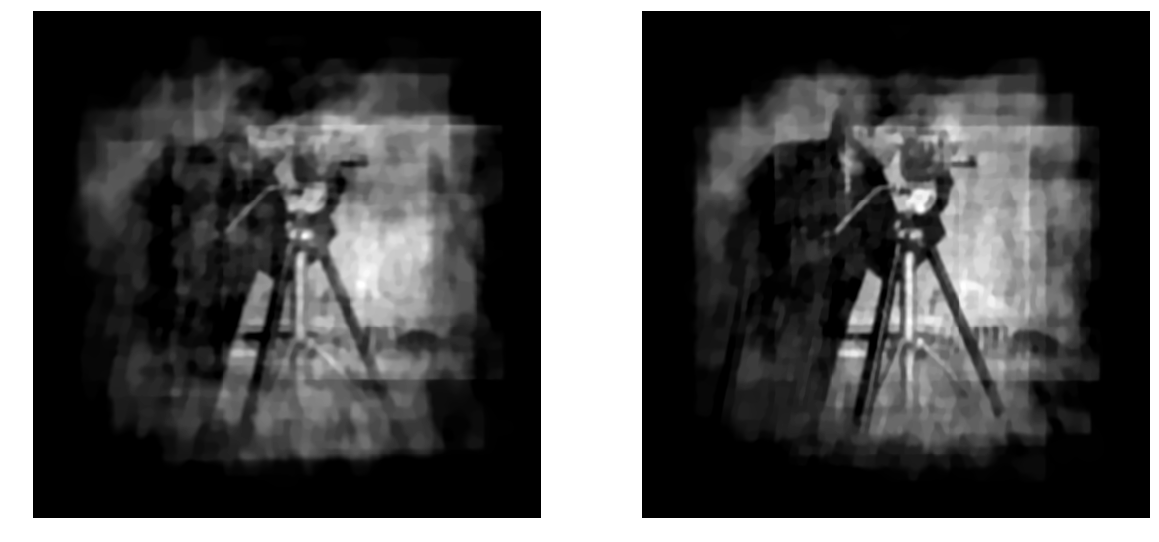

In [165]:
fig1, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(imlist[0],cmap='gray')
ax[0].axis('off')
ax[1].imshow(imlist[-1],cmap='gray')
plt.axis('off')

24.0
23.52941176470588


/Users/nick.antipa/anaconda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:78: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


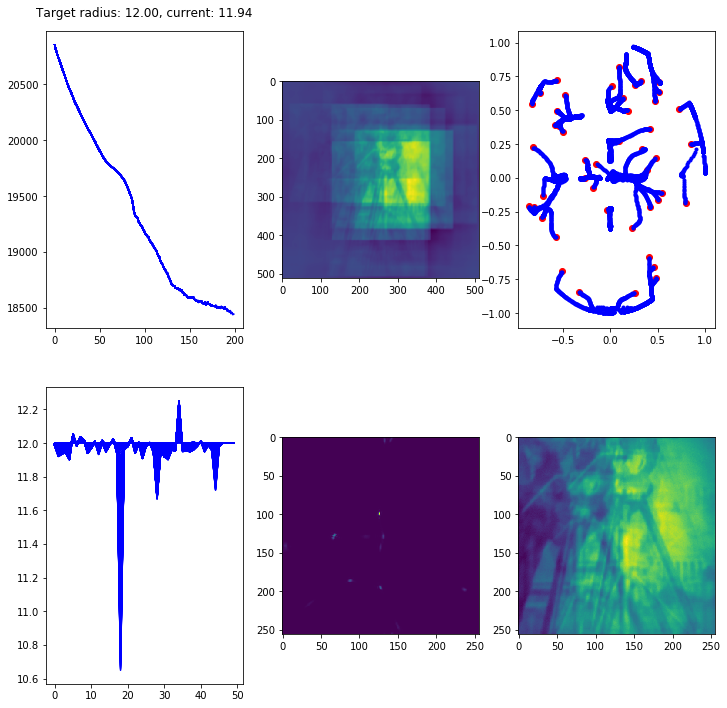

In [177]:
im_lenslets = im2


ior_lenslets = 1.51
target_rad_lenslets = lens_rad
f_lenslets = target_rad_lenslets/(ior_lenslets-1)
print(target_rad)
print(f_lenslets)
fig_single, ax_single = plt.subplots(2,3, figsize = (12,12))
R_list_lenslets = np.linspace(target_rad_lenslets-5, target_rad_lenslets+5, 10)
grad_lenslets = elementwise_grad(lenslet_loss_admm,argnum = (0,1,2))
vals = []
grad_vals = []
ims = []
x_list_init = np.random.rand(50)*1.8-.9
y_list_init = np.random.rand(50)*1.8-.9
good_lenslets = np.sqrt(x_list_init**2+y_list_init**2) < 1
x_learn = copy.deepcopy(x_list_init[good_lenslets])
y_learn = copy.deepcopy(y_list_init[good_lenslets])
x_learnk = x_learn
y_learnk = y_learn
N_lenslets_learning = len(x_list_init)


#imax1 = ax_single[1].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
#imax2 = ax_single[2].imshow(np.zeros_like(pad_func(psf_test, 1/2)))
imlist = []
niters_lenslets = 200
R_lensletsk = np.random.rand(Nlenslets_learning)*0 + 12.

R_learned_list_lenslets = []

step_size_x = 1.6e-5
step_size_y = step_size_x
step_size_lenslets = 1e-4
x_learned_list = []
y_learned_list = []
plot3 = ax_single[0,2].scatter(x_learn, y_learn, c='r')

for n in range(niters_lenslets):
    #v = singlet_loss_admm(R_single, f_lenslets, ior_lenslets, 3, im_lenslets)
    g, gx, gy = grad_lenslets(R_lensletsk, x_learn, y_learn, f_lenslets, ior_lenslets, 1, im_lenslets)
    #a = lenslet_loss_admm(np.array([R_lenslets]), x_list_init, y_list_init, f_lenslets, ior_lenslets, 1, im_lenslets)
    vals.append(loss_lenslets._value)
    
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
    R_lensletsp = R_lensletsk - step_size_lenslets * g
    R_lenslets = R_lensletsp + beta*(R_lensletsp - R_lensletsk)
    R_learned_list_lenslets.append(R_lenslets)
    R_lenslets = np.maximum(R_lenslets, 6)
    
    x_learnp = x_learn - step_size_x * gx
    x_learn = x_learnp + beta*(x_learnp - x_learnk)

    
    y_learnp = y_learn - step_size_y * gy
    y_learn = y_learnp + beta*(y_learnp - y_learnk)
    
    #Project back onto aperture
    lr = np.sqrt(y_learn**2 + x_learn**2)
    lr = np.minimum(lr, ca+.1)
    ya = np.arctan2(y_learn, x_learn)
    y_learn = lr * np.sin(ya)
    x_learn = lr * np.cos(ya)
    
    x_learned_list.append(x_learn)
    y_learned_list.append(y_learn)
    
    #print("Iter %i, cost %.2e" %(n,loss_lenslets._value))
    
    
    #grad_vals.append(g)
    
    
    
    if n > 3:
        if v>(10*vals[-2]):
            t = 1
        else:
            t = tp
            
    
    
    plot1, = ax_single[0,0].plot(vals, 'b')
    titax = ax_single[0,0].text(0.5,1.05,"Target radius: %.2f, current: %.2f" %(target_rad_lenslets, np.mean(R_lensletsk)), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax_single[0,0].transAxes,)
    titax.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='white'))
    
    plot2 = ax_single[0,2].scatter(x_learn, y_learn, c = 'b', marker='.')#ax_single[0,2].plot(R_lensletsk, 'b')
    #plot2.set_offsets(x_learn, y_learn)
    implot1 = ax_single[0,1].imshow(recon_lenslets._value, animated = True)
    imlist.append(recon_lenslets._value)
    #implot2 = ax_single[1,0].imshow(resid_im_lenslets._value, animated = True)
    implot2, = ax_single[1,0].plot(R_lensletsk, 'b')
    psfplot = ax_single[1,1].imshow(psf_lenslets._value, animated = True)
    measplot = ax_single[1,2].imshow(meas_lenslets._value, animated = True)
    #display.display(fig_single)
    #display.clear_output(wait=True)
    ims.append([plot1, plot2, implot1, implot2, psfplot, titax, measplot, plot3])
    
    #R_lensletsk = R_lenslets
    x_learnk = x_learn
    y_learnk = y_learn
    R_lensletsk = R_lenslets

In [179]:
ani = animation.ArtistAnimation(fig_single, ims, interval=10, blit = True, repeat_delay=10)
HTML(ani.to_html5_video())

In [180]:
ani.save('../learning_locations_and_radii_1reconiter.mp4', writer='ffmpeg', fps=10)

[-0.01852333 -0.26979503  0.95331063  0.75347103  2.77669281  2.91044993
  2.13398902 -0.3998171   2.61512104 -2.36507948 -2.84963693 -2.75173764
  0.60583759 -0.84251535  0.15280597 -2.4048782  -0.69160142  2.79839207
  1.94533454  0.15838946 -1.02937772 -0.16591122 -1.7825849  -1.47494314
 -1.20936115  0.98588495  0.80642283 -0.45612714  1.11315531  2.38531589
  0.47758069  1.950032   -0.74942724 -1.76798907 -1.22744112  0.71202462
  1.56987779  1.90125481  1.10860718 -0.26200873  1.69766053 -2.23459993
 -2.55952589 -3.00387921 -1.66525647 -0.56147003 -2.74840988  0.37108715]


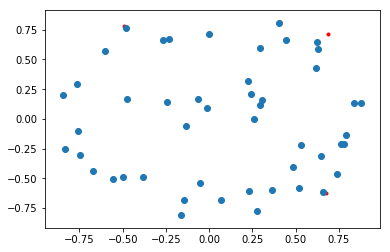

In [125]:
lr = np.sqrt(y_learn**2 + x_learn**2)
lr = np.minimum(lr, ca)
ya = np.arctan2(y_learn, x_learn)
y_new = lr * np.sin(ya)
x_new = lr * np.cos(ya)
print(ya)
plt.figure()
plt.scatter?
plt.scatter(x_learn, y_learn, c='r', marker='.')
plt.scatter(x_new, y_new)

In [95]:
grad_lenslets_xy = elementwise_grad(lenslet_loss_admm,argnum = (1,2))
gx, gy = grad_lenslets_xy(R_lensletsk, x_list_learn, y_list_learn, f_lenslets, ior_lenslets, 1, im_lenslets)
print(gx)
print(gy)

[ -57.43240146 -316.58867721   12.65606095 -383.10204966   19.99253531
   35.43540492  -55.67657351   91.24431277 -103.03430914 -209.61668692
 -104.62268924  -90.20744753  -35.54266493   30.46528155 -250.16565953
  -27.30095     -29.94390305   83.75751229  110.2328988    97.11992445
  -50.12373281 -360.52077326   18.50992523    7.35950423  -25.71451106
   48.51626781  -11.04232984   69.04092982   17.5037404   -56.14373306
  -44.37461166  -70.64176461   17.7402965   -14.24001278    4.13037393
   66.14039243  111.26843232  -18.88028723  -55.90858471   95.38184839
 -104.52100876  268.60853562    4.92877116   79.23008896]
[-2.56178382e+00 -1.24231049e+02  4.03126633e+00 -6.90206011e+02
  1.16798334e+00  7.57423254e+01 -2.17538216e+00  1.16316635e+02
 -3.08714152e+01  4.94565367e+01  1.20630252e+02 -1.93482485e+01
 -1.46014541e+01 -2.18170023e+01  1.72521096e+01  1.05961595e+02
  1.72948232e+01  2.94330372e+01 -3.15409162e+01 -7.79617822e+01
  7.89862947e+00 -3.34433960e+02  1.33522998e+01 

In [ ]:
plt.figure(figsize = plt.rcParams.get('figure.figsize'))
plt.imshow(np.random.rand(10,10))
test_opts = gen_options(mu2 = 10)
print(test_opts)

In [ ]:
cost_fun = lambda x,y,r:np.sum(make_lenslet_surface_ag(x,y,r,xg,yg,aperR))

In [ ]:
grad_cost = grad(cost_fun,argnum=(0,1,2))

In [ ]:
print(cost_fun(x1,y1,R))

In [ ]:
grad_vals = grad_cost(x1,y1,R)
print(grad_vals)

In [ ]:
from scipy import ndimage as ndim

In [ ]:
scl = .98
mat = np.array([[scl,0],
                [0,scl]])
offset = [(1-scl)*samples[0]/2, (1-scl)*samples[1]/2]
im_transformed = ndim.affine_transform(s,mat,offset)
plt.figure()
plt.imshow(im_transformed)

In [ ]:
im_padded = np.pad

In [ ]:
a = np.array([[10],[5]])
a.shape[1]

In [ ]:
plt.figure(),plt.imshow(s*aperR)

In [ ]:
def propagate_field(lam, ps, z, U):
    k = 2*np.pi/lam   
    siz = np.shape(U)
    fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
    fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
    x = np.linspace(-siz[1]/2*ps,siz[1]/2*ps,siz[1])
    y = np.linspace(-siz[0]/2*ps,siz[0]/2*ps,siz[0])
    X,Y = np.meshgrid(x,y)
    Fx,Fy = np.meshgrid(fx,fy)
    Uf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(U)))
    Hf = np.exp(1j*2*np.pi*z/lam * np.sqrt(1-(lam*Fx)**2 - (lam*Fy)**2))
    Up = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Uf*Hf)))
    return Up

In [ ]:
# def propagate_field_freq(lam, z, U, Fx, Fy, padfrac=0):
#     k = 2*np.pi/lam   
#     #siz = np.shape(U)
#     #fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
#     #fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
#     #x = np.linspace(-siz[1]/2*ps,siz[1]/2*ps,siz[1])
#     #y = np.linspace(-siz[0]/2*ps,siz[0]/2*ps,siz[0])
#     #X,Y = np.meshgrid(x,y)
#     #Fx,Fy = np.meshgrid(fx,fy)
#     if padfrac != 0:
#         shape_orig = np.shape(U)
#         U = pad_func(U, padfrac, 'edge')
#         Fx, Fy = np.meshgrid(np.linspace(np.min(Fx), np.max(Fx), U.shape[0], np.linspace(np.min(Fy), np.max(Fy), U.shape[1])))
        
#     Uf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(U)))
#     Hf = np.exp(1j*2*np.pi*z/lam * np.sqrt(1-(lam*Fx)**2 - (lam*Fy)**2))
#     Up = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Uf*Hf)))
#     if padfrac != 0:
#         Up = crop_func(Up, shape_orig)
#     return Up

In [ ]:
asdf = np.random.rand(10,10)

# def pad_func(x, padfrac,mode):
#     padr = [];#np.zeros(x.ndim).astype('int')
#     for n in range(x.ndim):
#         pw = np.ceil(padfrac*x.shape[n]).astype('int')
#         padr.append((pw,pw))
        
    
#     return np.pad(x,padr,mode)
test = pad_func(asdf,2,'edge')
plt.imshow(test)

In [ ]:
# def crop_func(x,crop_size):
#     cstart = []
#     cent = []
#     for n in range(x.ndim):
#         cstart.append((x.shape[n]-crop_size[n])//2)
#     slicer = tuple(slice(cstart[n],cstart[n]+crop_size[n],1) for n in range(len(crop_size)))
#     return(x[slicer])
        
asdf = np.zeros((100,100))
test = np.zeros((200,200))
test2 = crop_func(test,np.shape(asdf))
print(test2 == asdf)
plt.imshow(test2-asdf)

In [ ]:
jkl = np.zeros((10,5,5))
start_list = [1,2,1]
crop_size = [1,2,3]
print(jkl.shape)
cstart = ((jkl.shape[n] - crop_size[n]/2) for n in range(len(jkl.shape)))
print(cstart)
slist = [2,3,4]
slicer = tuple(slice(start_list[n],start_list[n]+slist[n],1) for n in range(len(slist)))
print(slicer)
jkl[slicer]
print(np.shape(jkl[slicer]))

In [ ]:
R_main = 10;
f_main = R_main/.51
print(f_main)
xoff = 1;
s2 = np.real(np.sqrt(1j*0+R_main**2-(xg-xoff)**2-yg**2))
plt.imshow(s2)

In [ ]:
# from IPython import display

lamb = 510e-6


wavefront_rad = 1/np.linspace(-.03,.03,50)


#ps = xrng[1]/samples[0]/2
#ps = (xrng[1] - xrng[0])/samples[0]
print(ps)
U_out = []
ind_ct = 0

pd = 0;
siz = np.shape(pad_func(xg,pd,'constant'))
fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
Fx, Fy = np.meshgrid(fx,fy)


In [ ]:
%%time

for rad in wavefront_rad:
    
    phs = rad*np.real(np.sqrt(1j*0 + 1 - (xg/rad)**2 - (yg/rad)**2))

    qphs = np.exp(1j*2*np.pi/lamb*phs)
    Uin = qphs * np.exp(1j*2*np.pi*.51*s/lamb)
    U_out.append(crop_func(propagate_field(lamb, ps, f_main,pad_func(aperR*Uin,1/4,'edge')),np.shape(Uin)))
    #U_out.append(propagate_field(lamb, ps, 28,aperR*Uin))
    #
    #U_out.append(qphs)
    #print(np.shape(U_out))
    #plt.imshow(np.abs(U_out[ind_ct])**2)
    #plt.imshow(np.angle(Uin))

    #display.display(fig1)
    #display.clear_output(wait=True)
    ind_ct+=1
    
    

In [ ]:
%%time
#fig1 = plt.figure(figsize=(10,10))
ind_ct = 0
for rad in wavefront_rad:
    
    phs = rad*np.real(np.sqrt(1j*0 + 1 - (xg/rad)**2 - (yg/rad)**2))

    qphs = np.exp(1j*2*np.pi/lamb*phs)
    Uin = qphs * np.exp(1j*2*np.pi*.51*s/lamb)
    U_out.append(crop_func(propagate_field_freq(lamb, f_main,pad_func(aperR*Uin,pd,'edge'),Fx, Fy),np.shape(Uin)))
    #U_out.append(propagate_field(lamb, ps, 28,aperR*Uin))
    #
    #U_out.append(qphs)
    #print(np.shape(U_out))
    #plt.imshow(np.abs(U_out[ind_ct])**2)
    #plt.imshow(np.angle(Uin))

    #display.display(fig1)
    #display.clear_output(wait=True)
    ind_ct+=1

In [ ]:
print(np.shape(U_out)[0])

In [ ]:
# ims0 = []
# fig = plt.figure()
# I_out = np.abs(U_out)**2
# print(np.shape(U_out))
# for t in range(np.shape(U_out)[0]):
#     im = plt.imshow((I_out[t]), interpolation = 'nearest', animated = True, cmap = 'viridis')
#     #plt.clim((0, np.max(I_out)/10))
#     plt.title(wavefront_rad[t])
#     plt.show()
#     ims0.append([im])

In [ ]:
# Try autofocusing a lens
import copy
phase_coeff = -.01;
qphs = phase_coeff*(xg**2 + yg**2)
U_q = np.exp(1j*2*np.pi/lamb * qphs)
#propagate_field_freq(lam, z, U, Fx, Fy):
print(np.shape(Fx))

# U_out = propagate_field_freq(lamb, 30, pad_func(aperR*(U_q), pd,'edge') , Fx, Fy)
U_out = (propagate_field_freq(lamb, 50, aperR*(U_q) , Fx, Fy))
psf = np.abs(U_out)**2
psf = psf/np.sum(psf)
plt.figure()
plt.imshow(psf)
#plt.imshow(np.angle(U_q))

In [ ]:
# import scipy.misc as misc


# im_in = misc.imread('/Users/nick.antipa/GoogleDrive_berkeley/EE123_2018/Section Notes/sec3/sec3_old/cameraman.tif').astype('float')


H = (np.fft.fft2(np.fft.ifftshift(pad_func(psf,1/4,'constant'))))
crop_conv = lambda x:crop_func(np.real(fft.ifft2(fft.fft2(pad_func(x,1/4,'edge'))*H)), np.shape(im_in))
#crop_conv = lambda x:crop_func(np.real(fft.ifft2(fft.fft2(x)*H)), np.shape(im_in))
#print(np.sum(np.abs(H)**2))
#print(np.sum(np.abs(psf)**2))
plt.figure()
plt.subplot(121)
plt.imshow(im_in)
plt.subplot(122)
plt.imshow(crop_conv(im_in))



In [ ]:

test = crop_conv(im_in)
plt.figure()
plt.imshow(test)

In [ ]:
loss_im = crop_conv(im_in) - im_in
plt.figure()
plt.imshow(loss_im)

In [ ]:
# sweep lens radius
fig = plt.figure()
err = []
z_dist = np.linspace(30,80,50)
z = 50
r_list = np.linspace(-.005,-.015,100)
for phase_coeff in r_list:
    qphs = phase_coeff*(xg**2 + yg**2)
    U_q = np.exp(1j*2*np.pi/lamb * qphs)
    U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
    psf = np.abs(U_p)**2
    psf = psf/np.sum(psf)

    H = (np.fft.fft2(np.fft.ifftshift(pad_func(psf,1/4,'constant'))))
    crop_conv = lambda x:crop_func(np.real(fft.ifft2(fft.fft2(pad_func(x,1/4,'edge'))*H)), np.shape(im_in))
    meas = crop_conv(im_in)
    resid = meas - im_in;
    err.append(np.sum(np.abs(resid)**2))
    plt.clf()
    plt.subplot(121)
    plt.imshow(np.abs(resid))
    plt.title('residual = ' + '%.4f '% err[-1])
    plt.subplot(122)
    plt.plot(r_list[:len(err)],err)
    display.display(fig)
    display.clear_output(wait=True)

In [ ]:
# Define losses
def im_loss(phase_coeff, im, z, lamb, aperR, Fx, Fy):
    qphs = phase_coeff*(xg**2 + yg**2)
    U_q = np.exp(1j*2*np.pi/lamb * qphs)
    U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
    psf = np.abs(U_p)**2
    psf = psf/np.sum(psf)    
    H = np.fft.fft2(np.fft.ifftshift(psf))
    crop_conv = lambda x:np.real(np.fft.ifft2(np.fft.fft2(x)*H))
    meas = crop_conv(im_in)
    resid = meas - im_in;
    err = np.sum(np.abs(resid)**2)

    return err



In [ ]:
def im_sim(phase_coeff, im, z, lamb, aperR, Fx, Fy):
    qphs = phase_coeff*(xg**2 + yg**2)
    U_q = np.exp(1j*2*np.pi/lamb * qphs)
    U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
    psf = np.abs(U_p)**2
    psf = psf/np.sum(psf)

#    H = (np.fft.fft2(np.fft.ifftshift(pad_func(psf,1/4,'constant'))))
    
    H = np.fft.fft2(np.fft.ifftshift(psf))
    crop_conv = lambda x:np.real(np.fft.ifft2(np.fft.fft2(x)*H))
    meas = crop_conv(im_in)
    resid = meas - im_in;
    err = np.sum(np.abs(resid)**2)
    #if disp_figs:
#    plt.clf()
#    plt.imshow(meas)
#    plt.title('eror = ' + '%.5e' % err)
#    display.display(fig_handle)
#    display.clear_output(wait=True)
    return meas, err

In [ ]:
fig4 = plt.figure()
err = []
for phase_coeff in r_list:
    err.append(im_loss(phase_coeff, im_in, z, lamb, aperR, Fx, Fy))
    plt.clf()
    plt.plot(err)
    
    #display.display(fig4)
    #display.clear_output(wait=True)

In [ ]:
%matplotlib inline
grad_cost = grad(im_loss)
phase_coeff = 0.0
step_size = .8e-14
fig5 = plt.figure()
t = 1
err_nesterov = []
for n in range(50):
    grad_vals = grad_cost(phase_coeff, im_in, z, lamb, aperR, Fx, Fy)
    meas, err_iter = im_sim(phase_coeff, im_in, z, lamb, aperR, Fx, Fy)
    err_nesterov.append(err_iter)
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
    phase_coeffp = phase_coeff - step_size * grad_vals
    phase_coeff = phase_coeffp + beta*(phase_coeffp - phase_coeff)
    if n > 3:
        if err_iter>err_nesterov[-2]:
            t = 1
        else:
            t = tp
        
    plt.clf()
    plt.imshow(meas)
    plt.title('eror = ' + '%.5e' % err_iter)
    display.display(fig5)
    display.clear_output(wait=True)
    
err_grad = []
phase_coeff_n = phase_coeff
phase_coeff = 0.0
for n in range(1):
    grad_vals = grad_cost(phase_coeff, im_in, z, lamb, aperR, Fx, Fy)
    meas, err_iter = im_sim(phase_coeff, im_in, z, lamb, aperR, Fx, Fy)
    err_grad.append(err_iter)
    #tp = (1 + np.sqrt(1+4*t**2))/2
    #beta = (t-1)/tp
    phase_coeff = phase_coeff - step_size * grad_vals
    #phase_coeff = (1-beta)*phase_coeffp + beta*phase_coeff
    #if err_iter>err_nesterov[-1]
    #t = tp
        #t = 0
    plt.clf()
    plt.imshow(meas)
    plt.title('eror = ' + '%.5e' % err_iter)
    display.display(fig5)
    display.clear_output(wait=True)
    


In [ ]:
plt.figure()
plt.plot(err_nesterov)
plt.plot(err_grad)

In [ ]:
def soft_2d_gradient(v,h,tau):

    mag = np.sqrt(np.vstack([v,np.zeros((1,v.shape[1]))])**2 + np.hstack((h,np.zeros((h.shape[0],1))))**2)
    magt = np.maximum(mag - tau,0)
    mag[mag<tau]=tau
    mmult = magt/mag
    #mmult[mag==0] = 0
    return v*mmult[:-1,:], h*mmult[:,:-1]

def update_param(mu, resid_tol, mu_inc, mu_dec, r, s):
    if r > resid_tol * s:
        mu_out = mu*mu_inc
        mu_update = 1
    elif r*resid_tol < s:
        mu_out = mu/mu_dec
        mu_update = -1
    else:
        mu_out = mu
        mu_update = 0
    return mu_out, mu_update

def TVnorm(x):
    result = 0
    for n in range(x.ndim):
        result += np.sum(np.abs(np.diff(x,axis=n)))
    return result

# y = crop(Hfor(pad(im_in)))    
# print(np.shape(y))

In [ ]:
# def admm2d(y, psf_in, tau, niter):
#     #niter = 100
#     #def admm_unrolled(b, psf, tau, iters):
#     #fig1 = plt.figure(figsize=(33,22))
#     mu1 = .1;
#     mu2 = .5;
#     mu3 = .8;
#     disp_interval = 20
#     resid_tol = 2
#     mu_inc = 1.2
#     mu_dec = 1.2
#     Ny, Nx = psf.shape
#     pad = lambda x:pad_func(x,1/2,'constant')
#     crop = lambda x:crop_func(x,np.shape(im_in))
#     H = np.fft.rfft2(np.fft.ifftshift(pad(psf)))
#     H_conj = np.conj(H)
#     Hfor = lambda x:np.fft.irfft2(H*np.fft.rfft2(x))
#     Hadj = lambda x:np.fft.irfft2(H_conj*np.fft.rfft2(x))

#     Cty = pad(y)
#     sk = np.zeros_like(Cty)
#     alpha1k = np.zeros_like(Cty)
#     alpha3k = np.zeros_like(Cty)
#     alpha3kp = np.zeros_like(Cty)
#     L = lambda D:(-np.diff(D,axis=0),-np.diff(D,axis=1))
#     Ltv = lambda P1,P2:np.vstack([P1[0,:],np.diff(P1,axis=0),-P1[-1,:]]) + np.hstack((P2[:,[0]],np.diff(P2,axis=1),-P2[:,[-1]]))
#     lapl = np.zeros_like(sk)
#     lapl[0,0]=4
#     lapl[0,1]=-1
#     lapl[1,0]=-1
#     lapl[0,-1]=-1
#     lapl[-1,0]=-1
#     LtL = abs(np.fft.rfft2(lapl))
#     alpha2k_1 = copy.deepcopy(sk[:-1,:])
#     alpha2k_2 = copy.deepcopy(sk[:,:-1])
#     HtH = H*H_conj
#     Smult = 1/(mu1*HtH + mu2*LtL + mu3)
#     CtC = pad(np.ones_like(y))
#     Vmult = 1/(CtC + mu1)
#     Hskp = np.zeros_like(Vmult)
#     dual_resid_s = []
#     primal_resid_s = []
#     dual_resid_u = []
#     primal_resid_u = []
#     dual_resid_w = []
#     primal_resid_w = []
#     cost = []
#     ukp_1, ukp_2 = L(np.zeros_like(y))
#     Lsk1 = ukp_1
#     Lsk2 = ukp_2

#     for n in range(niter):
#     #     Lskm1 = copy.deepcopy(Lsk1)
#     #     Lskm2 = copy.deepcopy(Lsk2)
#         Lsk1, Lsk2 = L(sk)

#         ukp_1, ukp_2 = soft_2d_gradient(Lsk1 + alpha2k_1/mu2, Lsk2 + alpha2k_2/mu2, tau/mu2)
#         Hsk = Hskp;   ##### DEEPCOPY!?
#         vkp = Vmult*(mu1*(alpha1k/mu1 + Hsk) + Cty)
#         wkp = np.maximum(alpha3k/mu3 + sk, 0)
#         skp_numerator = mu3*(wkp - alpha3k/mu3) + mu2*Ltv(ukp_1 - alpha2k_1/mu2, ukp_2 - alpha2k_2/mu2) + mu1 * Hadj(vkp - alpha1k/mu1)
#         skp = np.real(np.fft.irfft2(Smult * np.fft.rfft2(skp_numerator)))

#         Hskp = Hfor(skp)
#         r_sv = Hskp - vkp
#         dual_resid_s.append(mu1 * np.linalg.norm(Hsk - Hskp,'fro'))
#         primal_resid_s.append(np.linalg.norm(r_sv,'fro'))
#         mu1, mu1_update = update_param(mu1, resid_tol, mu_inc, mu_dec, primal_resid_s[-1], dual_resid_s[-1])
#         alpha1k += mu1*r_sv

#         Lskp1, Lskp2 = L(skp)
#         r_su_1 = Lskp1 - ukp_1
#         r_su_2 = Lskp2 - ukp_2
#         dual_resid_u.append(mu2*np.sqrt(np.linalg.norm(Lsk1 - Lskp1,'fro')**2 + np.linalg.norm(Lsk2 - Lskp2,'fro')**2))
#         primal_resid_u.append(np.sqrt(np.linalg.norm(r_su_1,'fro')**2 + np.linalg.norm(r_su_2,'fro')**2))
#         mu2, mu2_update = update_param(mu2, resid_tol, mu_inc, mu_dec, primal_resid_u[-1], dual_resid_u[-1])
#         alpha2k_1+= mu2*r_su_1
#         alpha2k_2+= mu2*r_su_2


#         r_sw = skp - wkp
#         dual_resid_w.append(mu2*np.linalg.norm(sk - skp,'fro'))
#         primal_resid_w.append(np.linalg.norm(r_sw,'fro'))
#         mu3, mu3_update = update_param(mu3, resid_tol, mu_inc, mu_dec, primal_resid_w, dual_resid_w)
#         alpha3k += mu3*r_sw

#         mu_update = 0
#         if mu1_update or mu2_update or mu3_update:
#             mu_update = 1
#             Smult = 1/(mu1*HtH + mu2*LtL + mu3)
#             Vmult = 1/(CtC + mu1)

#         sk = skp;
#         cost.append(np.linalg.norm(crop(Hskp)-y,'fro')**2 + tau*TVnorm(skp))
    
#     return sk
# #         if n % disp_interval == 0: 

# #             plt.subplot(231)
# #             plt.imshow(skp,vmax = np.percentile(skp,99))

# #             plt.subplot(232)
# #             if n==0:
# #                 p1 = plt.plot(cost)
# #             else:
# #                 p1.clear()
# #                 p1 = plt.plot(cost)
# #             plt.title('cost. Mu update: %i' %mu_update)

# #             plt.subplot(233)
# #             if n == 0:
# #                 pds = plt.plot(dual_resid_s)
# #                 pps = plt.plot(primal_resid_s)
# #             else:
# #                 pds.clear()
# #                 pps.clear()            
# #                 pds = plt.plot(dual_resid_s)
# #                 pps = plt.plot(primal_resid_s)
# #             plt.title('s residual')

# #             plt.subplot(234)
# #             plt.clf
# #             plt.plot(dual_resid_u)
# #             plt.plot(primal_resid_u)
# #             plt.title('u residual')

# #             plt.subplot(235)
# #             plt.clf
# #             plt.plot(dual_resid_w)
# #             plt.plot(primal_resid_w)
# #             plt.title('w residual')

# #             display.display(fig1)
# #             display.clear_output(wait=True)
        
        

    
    
    
    
    
    
    

In [ ]:
%matplotlib inline

im2 = imresize(im_in, tuple([2*x for x in np.shape(im_in)]))
H_test = np.fft.rfft2(np.fft.ifftshift(pad_func(psf,1/2,'constant')))

A = lambda x:crop_func(np.fft.irfft2(H_test*np.fft.rfft2(x)), tuple(int(.5*y) for y in np.shape(x)))

y = A(im2)
im_recon = admm2d(y, .1, 10)
plt.figure(figsize=(15,15))
plt.imshow(y)

In [ ]:

print(tuple([2*x for x in np.shape(im_in)]))

print(np.shape(im2))
qphs = phase_coeff*(xg**2 + yg**2)
U_q = np.exp(1j*2*np.pi/lamb * qphs)
U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
psf = np.abs(U_p)**2
psf = psf/np.sum(psf)    
H = np.fft.rfft2(np.fft.ifftshift(pad_func(psf,1/2,'constant')))
#crop_conv = lambda x:crop_func(np.fft.irfft2(np.fft.rfft2(pad_func(x,1/2,'constant'))*H),np.shape(psf))
crop_conv = lambda x:crop_func(np.fft.irfft2(np.fft.rfft2(x)*H),np.shape(psf))
meas = crop_conv(im2)
reconed = admm2d(meas, psf, .1, 10)
resid = reconed - im2;
err = np.sum(np.abs(resid)**2)
plt.figure(figsize=(20,20))
plt.imshow(np.abs(resid),vmin=0)

In [ ]:
def im_loss_admm(phase_coeff, im, z, lamb, aperR, Fx, Fy, tau, niter):
    qphs = phase_coeff*(xg**2 + yg**2)
    U_q = np.exp(1j*2*np.pi/lamb * qphs)
    U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
    psf = np.abs(U_p)**2
    psf = psf/np.sum(psf)    
    H = np.fft.rfft2(np.fft.ifftshift(pad_func(psf,1/2,'constant')))
    #crop_conv = lambda x:crop_func(np.fft.irfft2(np.fft.rfft2(pad_func(x,1/2,'constant'))*H),np.shape(psf))
    crop_conv = lambda x:crop_func(np.fft.irfft2(np.fft.rfft2(x)*H),np.shape(psf))
    meas = crop_conv(im)
    reconed = admm2d(meas, psf, .1, 10)
    resid = reconed - im;
    err = np.sum(np.abs(resid)**2)

    return err

In [ ]:
phase_coeff = -.007
qphs = phase_coeff*(xg**2 + yg**2)
U_q = np.exp(1j*2*np.pi/lamb * qphs)
U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
psf = np.abs(U_p)**2
psf = psf/np.sum(psf)    

H = np.fft.rfft2(np.fft.ifftshift(pad_func(psf,1/2,'constant')))
#crop_conv = lambda x:crop_func(np.fft.irfft2(np.fft.rfft2(pad_func(x,1/2,'constant'))*H),np.shape(psf))
crop_conv = lambda x:crop_func(np.fft.irfft2(np.fft.rfft2(x)*H),np.shape(psf))
meas = crop_conv(im)
plt.figure()
plt.imshow(meas)
print(np.shape(psf))
print(np.shape(im))
reconed = admm2d(meas, psf, .1, 10)
print(np.shape(reconed))
resid = reconed - im;
err = np.sum(np.abs(resid)**2)
plt.imshow(resid)
plt.figure()
plt.imshow(psf)
print(err)

In [ ]:
# Sweep lens curvature and plot error
%matplotlib inline
r_list = np.linspace(-.007,-.013,10)
fig8 = plt.figure(figsize=(26,13))
err = []
im2 = imresize(im_in, tuple([2*x for x in np.shape(im_in)]))
for phase_coeff in r_list:
    err.append(im_loss_admm(phase_coeff, im2, z, lamb, aperR, Fx, Fy, .01, 1))
    qphs = phase_coeff*(xg**2 + yg**2)
    U_q = np.exp(1j*2*np.pi/lamb * qphs)
    U_p = (propagate_field_freq(lamb, z, aperR*(U_q) , Fx, Fy))
    psf_r = np.abs(U_p)**2
    psf_r = psf_r/np.sum(psf_r)   
    H_test = np.fft.rfft2(np.fft.ifftshift(pad_func(psf_r,1/2,'constant')))

    A = lambda x:crop_func(np.fft.irfft2(H_test*np.fft.rfft2(x)), tuple(int(.5*y) for y in np.shape(x)))
    imreconned = admm2d(A(im2),psf_r, .01, 1)
    plt.clf()
    plt.subplot(131)
    plt.plot(err)
    
    plt.subplot(132)
    plt.imshow(imreconned)

    
    plt.subplot(133)
    plt.imshow(psf_r)
    
    
    display.display(fig8)
    display.clear_output(wait=True)

In [ ]:
# Optimize lens
%matplotlib inline
grad_cost_admm = grad(im_loss_admm)
phase_coeff = 0.0
step_size = .8e-14
fig5 = plt.figure()
t = 1
err_nesterov = []
for n in range(50):
    grad_vals = grad_cost_admm(phase_coeff, im2, z, lamb, aperR, Fx, Fy, .01, 10)
    meas, err_iter = im_sim(phase_coeff, im_in, z, lamb, aperR, Fx, Fy)    
    err_nesterov.append(err_iter)
    tp = (1 + np.sqrt(1+4*t**2))/2
    beta = (t-1)/tp
    phase_coeffp = phase_coeff - step_size * grad_vals
    phase_coeff = phase_coeffp + beta*(phase_coeffp - phase_coeff)
    if n > 3:
        if err_iter>err_nesterov[-2]:
            t = 1
        else:
            t = tp
        
    plt.clf()
    plt.imshow(meas)
    plt.title('eror = ' + '%.5e' % err_iter)
    display.display(fig5)
    display.clear_output(wait=True)